In [10]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from vae_utils import generate_data, standard_vae, contrastive_vae, plot_latent_space, plot_latent_space4d, contrastive_vae_no_bias
#plot_clean_digits, plot_clean_digits_only, plot_sweeps_mnist, plot_clean_digits_vae
from sklearn.metrics import silhouette_score

%matplotlib inline
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [14]:
contrastive_vae

<function vae_utils.contrastive_vae>

In [11]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
done, mounted


NameError: ignored

In [5]:
cd '/content/drive/My Drive/BC-MRI-AE'

/content/drive/My Drive/BC-MRI-AE


In [7]:
cd 'contrastive_vae'

/content/drive/My Drive/BC-MRI-AE/contrastive_vae


In [12]:
ls

'CelebA Experiments.ipynb'         LICENSE                     utils.py
 celeb_utils.py                    __pycache__/                vae_utils.py
'Grassy-MNIST Experiments.ipynb'   README.md
 helper.py                        'RNASeq Experiments.ipynb'


# Load the Dataset

In [13]:
import numpy as np, h5py, os
import matplotlib.pyplot as plt
from operator import itemgetter 
from scipy.sparse import vstack, coo_matrix, csc_matrix, isspmatrix_csc
%matplotlib inline

fnames = ['aml027_post',    
          'aml027_pre',     
          'aml035_post',    
          'aml035_pre',     
          'bmmc_healthy_1', 
          'bmmc_healthy_2', 
         ] 

path_prefix = '/home/a12d/home/a12d/rna/' #Replace with your own path

path_suffix = '/filtered_matrices_mex/hg19/matrix.mtx'

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

For faster access, save all of the files as h5py files.

In [ ]:
def gen_path(fname):
    return path_prefix + fname + path_suffix

for fname in fnames:
    if not(os.path.isfile(path_prefix+fname+'.h5')): # returns whether the h5 file exists or not    
        data = np.genfromtxt(gen_path(fname),delimiter=' ',skip_header=3,filling_values=0)
        row = data[:,1]-1 #1-indexed
        col = data[:,0]-1 #1-indexed
        values = data[:,2]
        print('Filename read:',fname)
        with h5py.File(path_prefix+fname+'.h5', 'w') as hf:
            hf.create_dataset("filtered_matrix",  data=data)    
        print('Filename written:',fname)
print("Done")

Done


# Preprocess to Reduce # of Genes

In [ ]:
from vae_utils import Dataset
%matplotlib inline

class SingleCell(Dataset):

    def __init__(self, active_files, background_file, N_GENES = 500, to_standardize=True, verbose=True): 
        self.active = vstack([self.file_to_features(fname) for fname in active_files])
        self.bg = vstack([self.file_to_features(fname) for fname in background_file])
        self.reduce_features(N_GENES)
        self.data = np.concatenate((self.active, self.bg),axis=0)
        self.active_labels = np.concatenate([self.file_to_labels(fname, l) for l, fname in enumerate(active_files)])
                
        # Pre-processing - done in main class
        if (verbose):
            print("Data size\t\t", self.data.shape)
            print("Active dataset size: \t", self.active.shape)
            print("Background dataset size:", self.bg.shape)
        super(self.__class__, self).__init__(to_standardize=to_standardize)
        self.pca_active()
        
    def description():
        print("To Add")
        
    def file_to_features(self, fname):
        with h5py.File(path_prefix+fname+'.h5', 'r') as hf:
            data = hf['filtered_matrix'][:]
        row = data[:,1]-1; row = row.astype(int) #1-indexed
        col = data[:,0]-1; col = col.astype(int) #1-indexed
        values = data[:,2]; values = values.astype(int) 
        c = csc_matrix((values, (row, col)), shape=(row.max()+1, col.max()+1))
        return c
    
    def reduce_features(self, N_GENES):
        n_active = self.active.shape[0]
        n_bg     = self.bg.shape[0]
        c = vstack((self.active, self.bg), format="csc")
        nonzero_idx = np.where(np.amax(c, axis=0).toarray().flatten()>0)[0]
        c = c[:,nonzero_idx]
        c = c.toarray()
        total_dispersion = np.var(c,axis=0)/np.mean(c,axis=0)
        ind = np.argpartition(total_dispersion, -N_GENES)[-N_GENES:].flatten()
        c = c[:,ind]
        self.active = c[:n_active]
        self.bg     = c[-n_bg:]

    def file_to_labels(self, fname, l):
        with h5py.File(path_prefix+fname+'.h5', 'r') as hf:
            data = hf['filtered_matrix'][:]
        row = data[:,1]-1; row = row.astype(int) #1-indexed
        col = data[:,0]-1; col = col.astype(int) #1-indexed
        values = data[:,2]; values = values.astype(int)
        c = coo_matrix((values, (row, col)), shape=(row.max()+1, col.max()+1))
        c = c.toarray()
        num_cells = c.shape[0]
        labels = np.repeat([l], num_cells)
        return labels

# Run Standard and Contrastive PCA (2 Groups)

In [ ]:
import matplotlib

active_file_idx = [0,1, 2, 3]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[4]])
colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']

projected_data, alphas = dataset.automated_cpca(max_log_alpha=3)
active_labels = dataset.get_active_labels()

Data size		 (14384, 500)
Active dataset size: 	 (12399, 500)
Background dataset size: (1985, 500)


/home/a12d/home/a12d/contrast_generative/vae_utils.py:896: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


[0.00000000e+00 1.00000000e-01 1.26638017e-01 1.60371874e-01
 2.03091762e-01 2.57191381e-01 3.25702066e-01 4.12462638e-01
 5.22334507e-01 6.61474064e-01 8.37677640e-01 1.06081836e+00
 1.34339933e+00 1.70125428e+00 2.15443469e+00 2.72833338e+00
 3.45510729e+00 4.37547938e+00 5.54102033e+00 7.01703829e+00
 8.88623816e+00 1.12533558e+01 1.42510267e+01 1.80472177e+01
 2.28546386e+01 2.89426612e+01 3.66524124e+01 4.64158883e+01
 5.87801607e+01 7.44380301e+01 9.42668455e+01 1.19377664e+02
 1.51177507e+02 1.91448198e+02 2.42446202e+02 3.07029063e+02
 3.88815518e+02 4.92388263e+02 6.23550734e+02 7.89652287e+02
 1.00000000e+03]


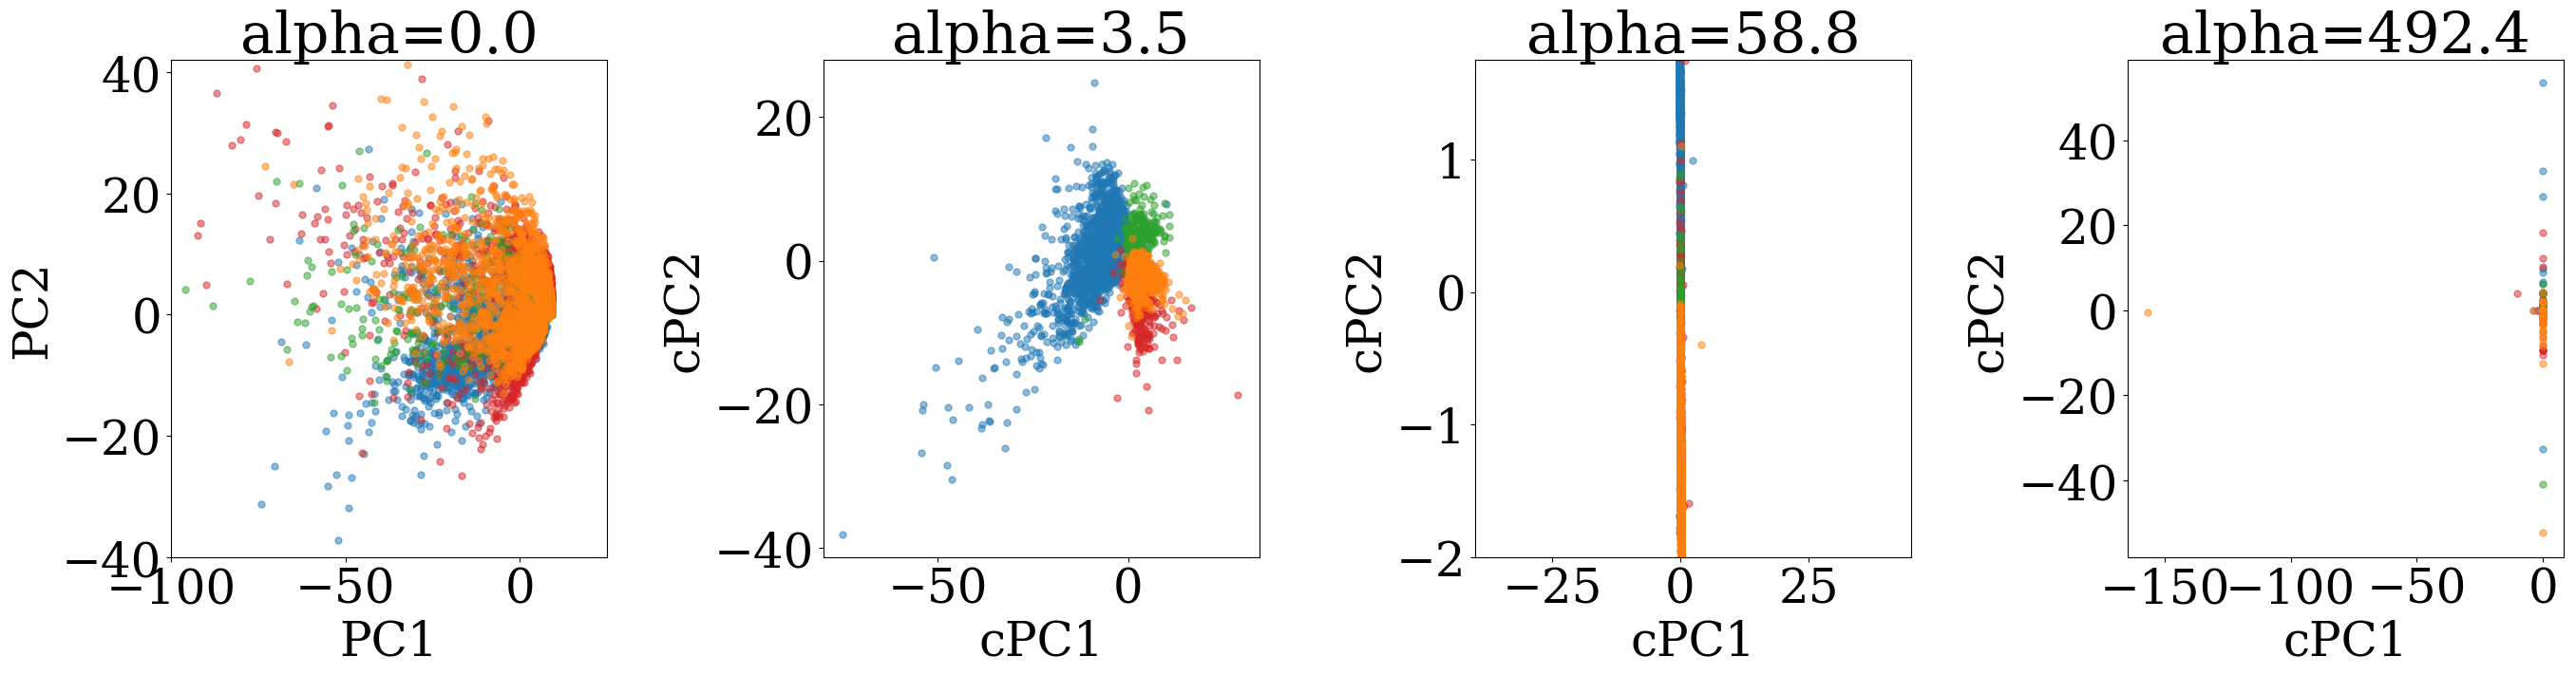

In [ ]:
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 36})
plt.rc('font', family='serif')

plt.figure(figsize=[28,8])
for j, (fg,bg) in enumerate(projected_data):
    plt.subplot(1,4,j+1)
    if (j==0):
        plt.title('PCA')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    else:
        plt.title('cPCA')
        plt.xlabel('cPC1')
        plt.ylabel('cPC2')
    if (j==1 or j==2):
        fg[:,0] = -fg[:,0]
    for i, l in enumerate((np.sort(np.unique(active_labels)))):
        idx = np.where(active_labels==l)[0]
        plt.scatter(fg[idx,0],fg[idx,1], color=colors[i], alpha=0.5, s=25)
    plt.title(r'alpha=' +str(np.round(alphas[j],1)))
    plt.locator_params(nbins=4, axis='x')
    plt.locator_params(nbins=6, axis='y')
    if (j==0):
        plt.xlim([-100, 25])
        plt.ylim([-40, 42])
    if (j==2):
        plt.xlim([-40, 45])
        plt.ylim([-2, 1.75])   
    plt.tight_layout()    

# VAE vs. cVAEs

Data size		 (9883, 500)
Active dataset size: 	 (7898, 500)
Background dataset size: (1985, 500)


/home/a12d/home/a12d/contrast_generative/vae_utils.py:896: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


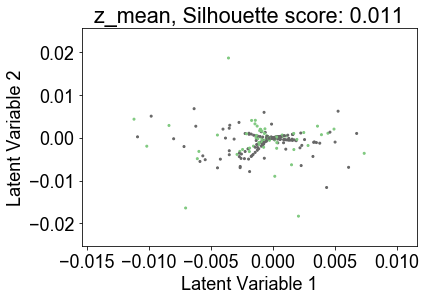

<Figure size 432x288 with 0 Axes>

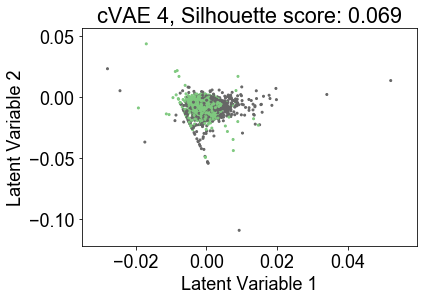

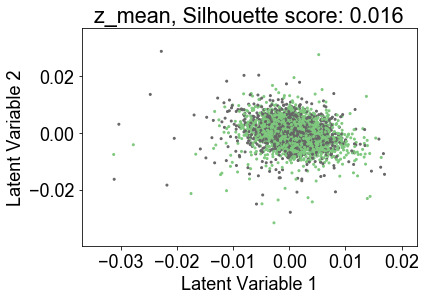

<Figure size 432x288 with 0 Axes>

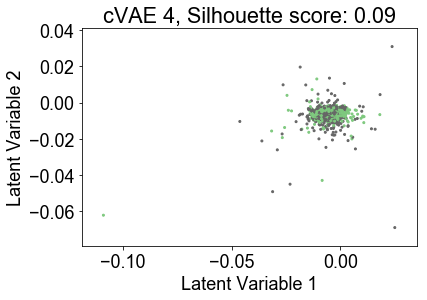

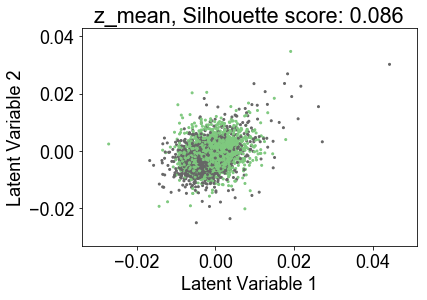

<Figure size 432x288 with 0 Axes>

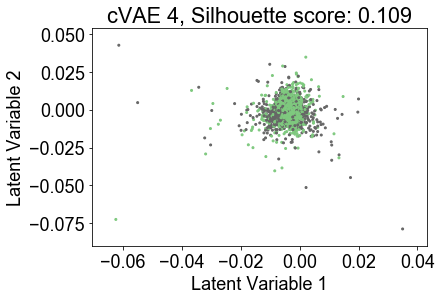

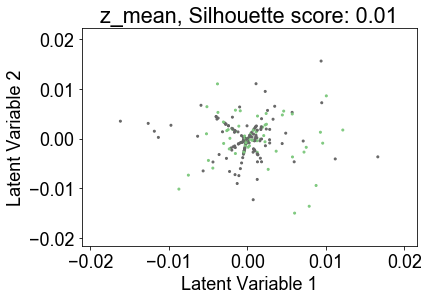

<Figure size 432x288 with 0 Axes>

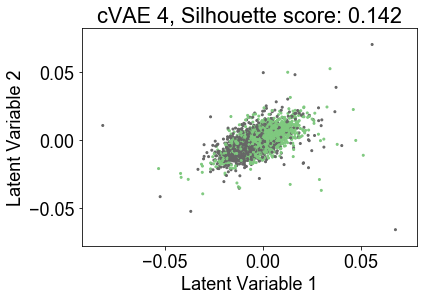

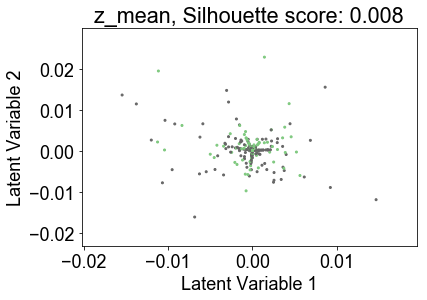

<Figure size 432x288 with 0 Axes>

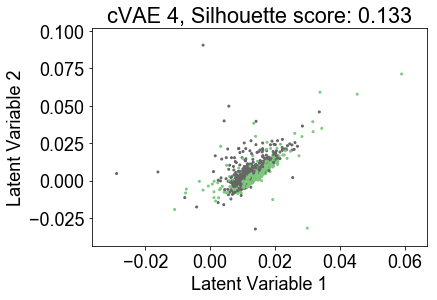

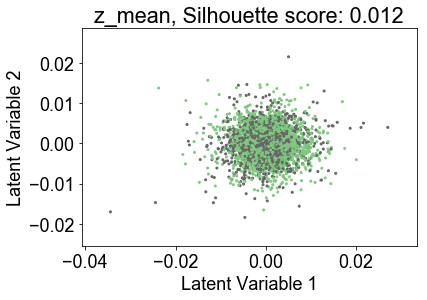

<Figure size 432x288 with 0 Axes>

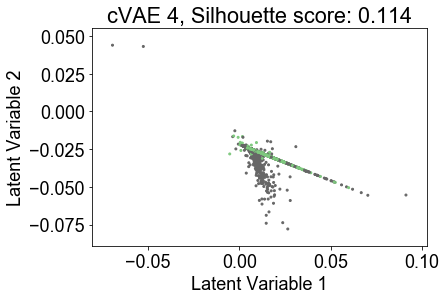

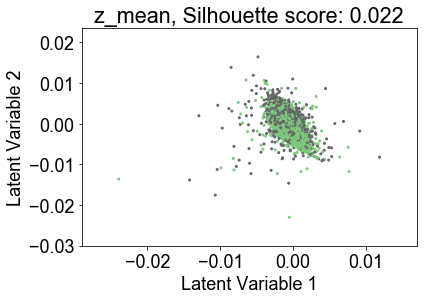

<Figure size 432x288 with 0 Axes>

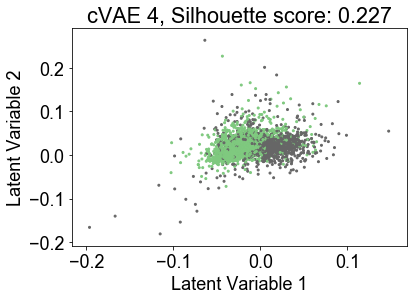

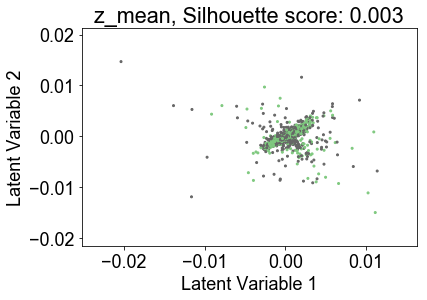

<Figure size 432x288 with 0 Axes>

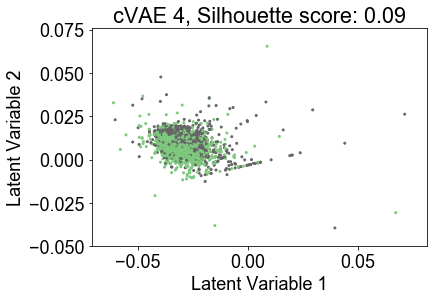

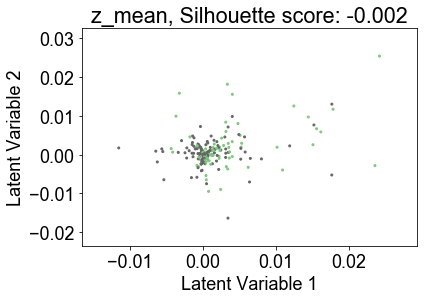

<Figure size 432x288 with 0 Axes>

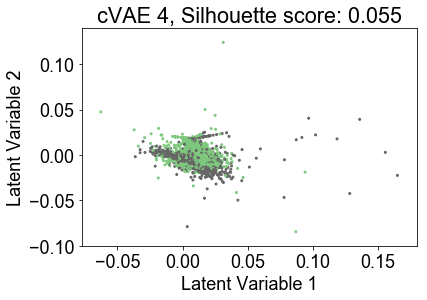

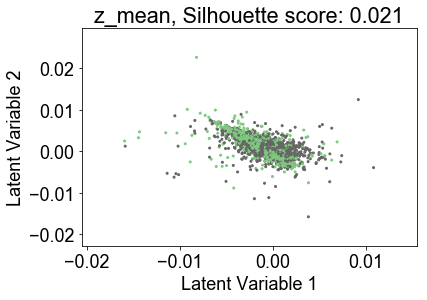

<Figure size 432x288 with 0 Axes>

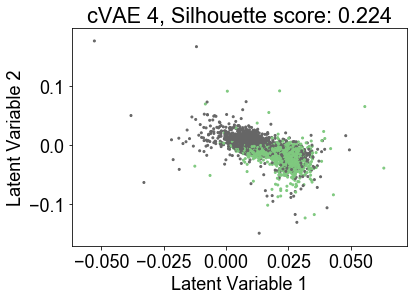

In [ ]:
iters = 10
s_scores = np.zeros((iters,)) 
c_scores = np.zeros((iters,)) 
s_points = list()
c_points = list()
t_labels = list()

np.random.seed(1)

active_file_idx = [0, 1]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[4]])
latent_dim_s = 4

colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']


target = dataset.get_active()
background = dataset.get_bg()
target_labels = dataset.get_active_labels()
n = int(target.shape[0]/128)*128
repeats = int(n/background.shape[0]) + 1

for i in range(iters):
    order = np.random.permutation(n)

    target = target[:n, :][order]
    target_labels = target_labels[:n][order]
    
    t_labels.append(target_labels)
    
    background = np.repeat(background, repeats, axis=0)[:n, :]

    target = (target - target.min())/(target.max() - target.min())
    background = (background - background.min())/(background.max() - background.min())

    vae, encoder, decoder = standard_vae(input_dim=500, intermediate_dim=32, 
                                         latent_dim=2)


    history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
    ss, z_mean = plot_latent_space(encoder, target, target_labels, s=4, return_points=True)
    s_scores[i] = ss
    s_points.append(z_mean)

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
        batch_size = 128, input_dim=500, intermediate_dim=32, latent_dim=2, 
        latent_dim_s=latent_dim_s, disentangle=False, gamma=1)

    history = cvae.fit([target, background], epochs=50, batch_size=128, 
                       validation_data=([target, background], None), verbose=0)


    plt.figure()
    ss, z_mean = plot_latent_space(z_encoder, target, target_labels, name='cVAE ' + str(latent_dim_s), plot=True, s=4, return_points=True)
    c_scores[i] = ss
    c_points.append(z_mean)
    

np.save('rna_results/0-1-4-s_scores4', s_scores)
np.save('rna_results/0-1-4-c_scores4', c_scores)
np.save('rna_results/0-1-4-s_points4', s_points)
np.save('rna_results/0-1-4-c_points4', c_points)
np.save('rna_results/0-1-4-t_labels4', t_labels)

In [ ]:
s_points = np.load('rna_results/0-1-4-s_points4.npy')
c_points = np.load('rna_results/0-1-4-c_points4.npy')
t_labels = np.load('rna_results/0-1-4-t_labels4.npy')

Text(0.5, 1.0, 'VAE, Silhouette score 0.012')

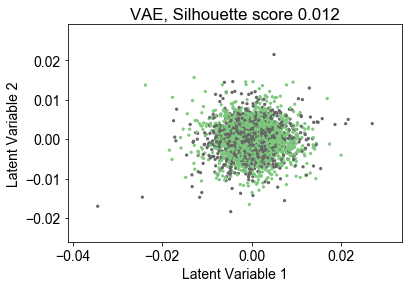

In [ ]:
from sklearn.metrics import silhouette_score

z_mean = s_points[5]
y = t_labels[5]

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

ss = round(silhouette_score(z_mean, y), 3)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, s=5, cmap='Accent')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('VAE, Silhouette score ' + str(ss))

Text(0.5, 1.0, 'cVAE, Silhouette score 0.227')

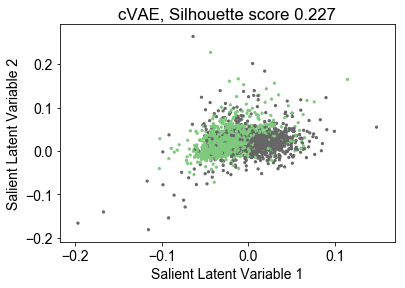

In [ ]:
from sklearn.metrics import silhouette_score

z_mean = c_points[6]
y = t_labels[6]

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

ss = round(silhouette_score(z_mean, y), 3)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y, s=5, cmap='Accent')
plt.xlabel('Salient Latent Variable 1')
plt.ylabel('Salient Latent Variable 2')
plt.title('cVAE, Silhouette score ' + str(ss))

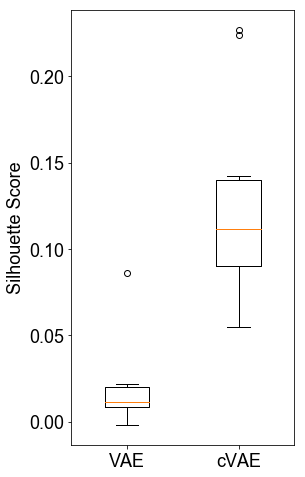

In [ ]:
s_scores = np.load('rna_results/0-1-4-s_scores4.npy')
c_scores = np.load('rna_results/0-1-4-c_scores4.npy')
s_points = np.load('rna_results/0-1-4-s_points4.npy')
c_points = np.load('rna_results/0-1-4-c_points4.npy')

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[4, 8])
plt.boxplot([s_scores, c_scores], vert=True, widths=0.4)
plt.xticks([1, 2], ['VAE', 'cVAE'])
plt.ylabel('Silhouette Score')
plt.show()

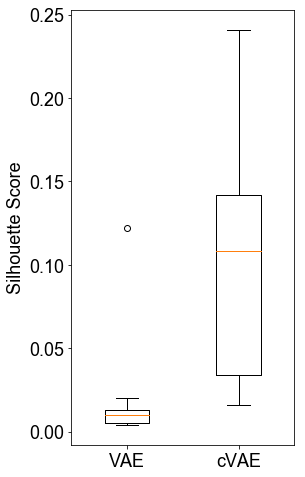

In [ ]:
s_scores = np.load('rna_results/0-1-4-s_scores3.npy')
c_scores = np.load('rna_results/0-1-4-c_scores3.npy')
s_points = np.load('rna_results/0-1-4-s_points3.npy')
c_points = np.load('rna_results/0-1-4-c_points3.npy')

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[4, 8])
plt.boxplot([s_scores, c_scores], vert=True, widths=0.4)
plt.xticks([1, 2], ['VAE', 'cVAE'])
plt.ylabel('Silhouette Score')
plt.show()

### Latent Dim = 6

Data size		 (10370, 500)
Active dataset size: 	 (7898, 500)
Background dataset size: (2472, 500)


/home/a12d/home/a12d/contrast_generative/vae_utils.py:896: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


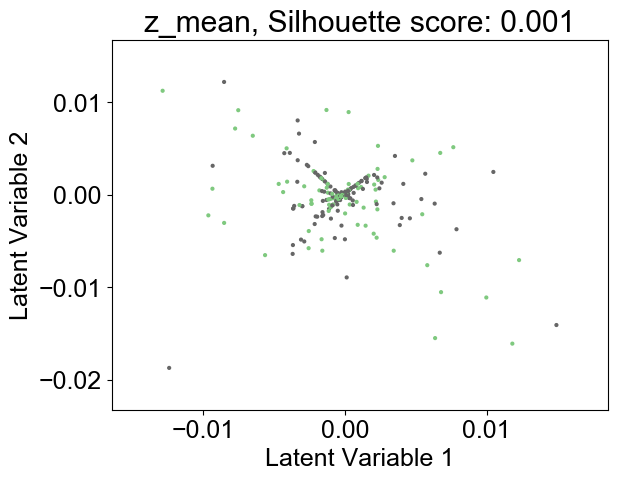

<Figure size 640x480 with 0 Axes>

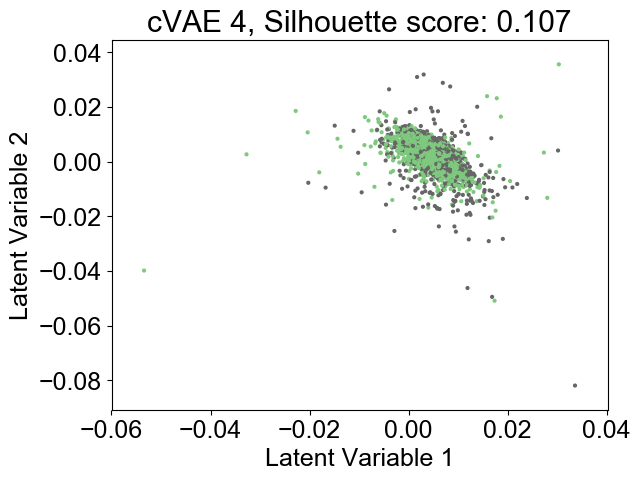

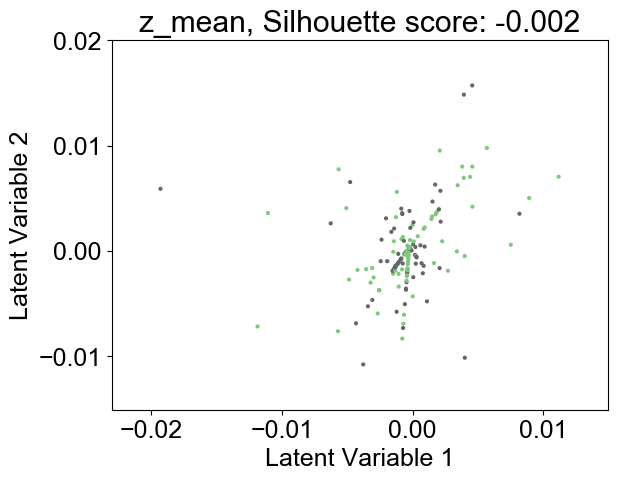

<Figure size 640x480 with 0 Axes>

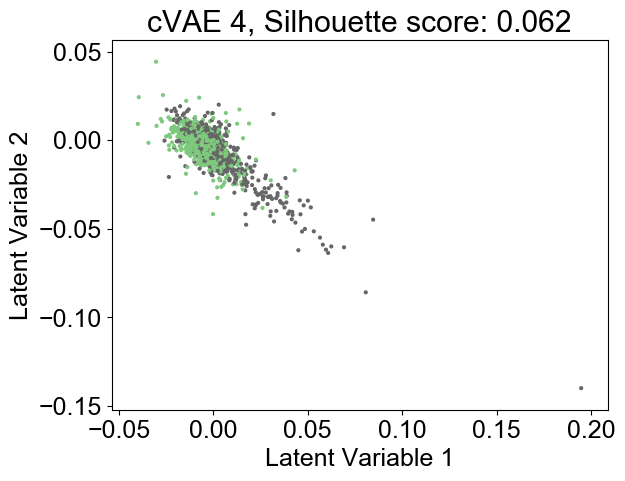

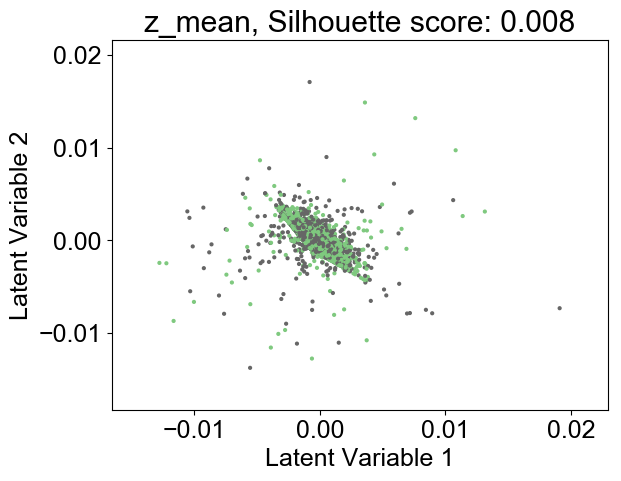

<Figure size 640x480 with 0 Axes>

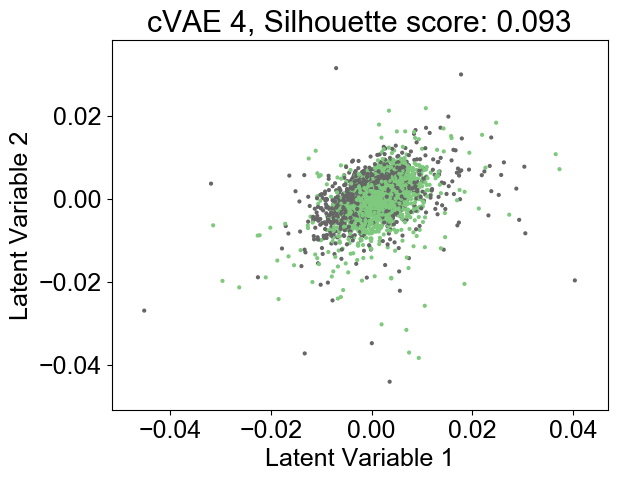

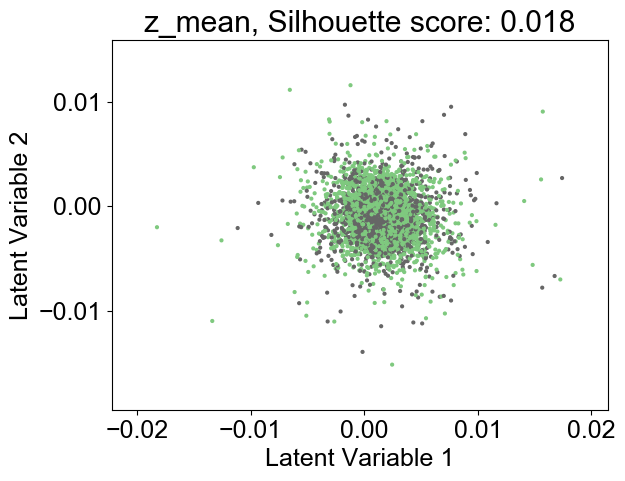

<Figure size 640x480 with 0 Axes>

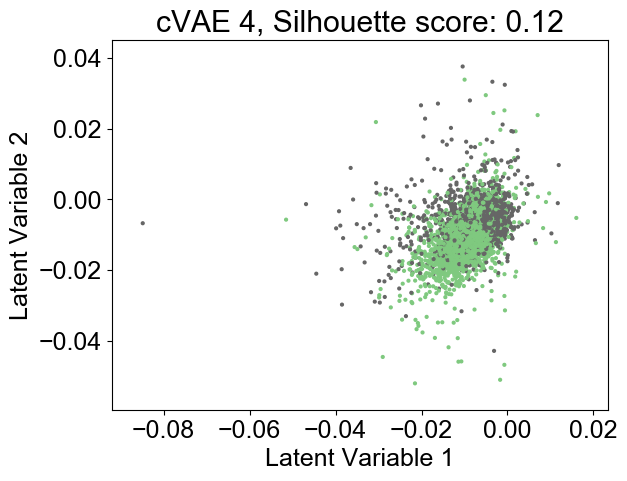

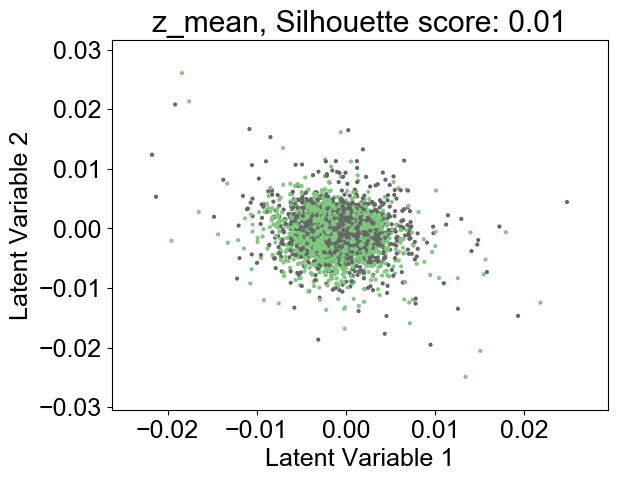

<Figure size 640x480 with 0 Axes>

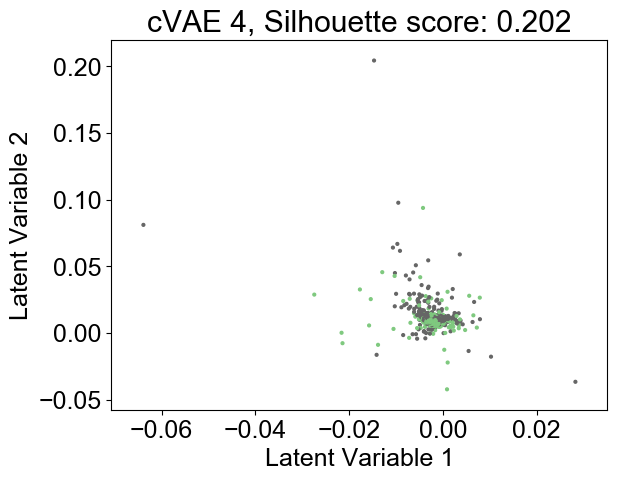

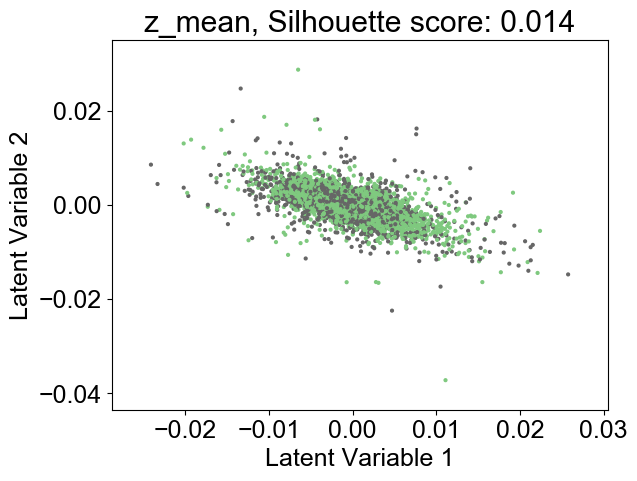

<Figure size 640x480 with 0 Axes>

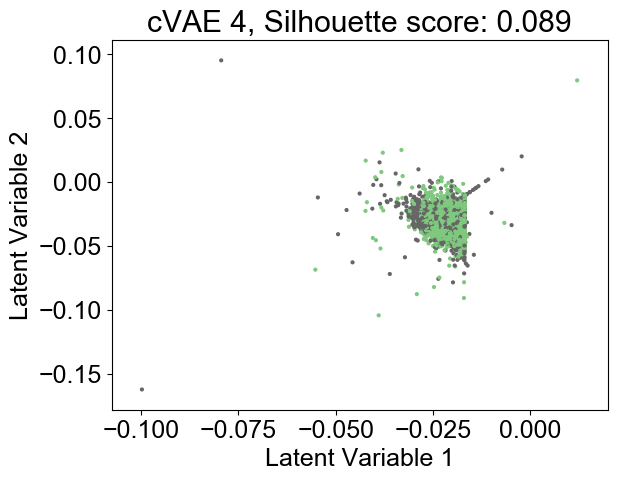

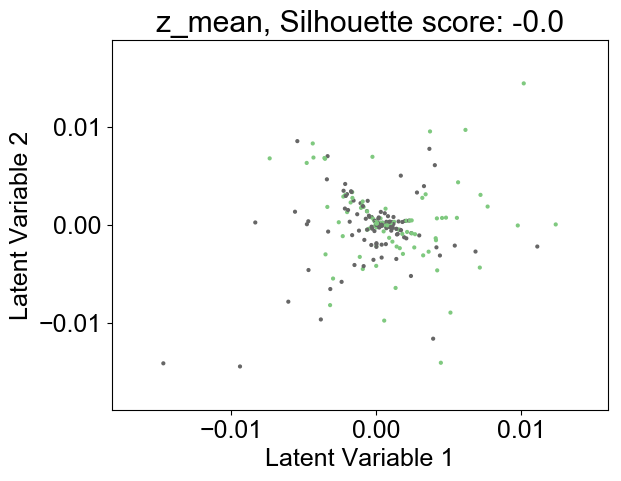

<Figure size 640x480 with 0 Axes>

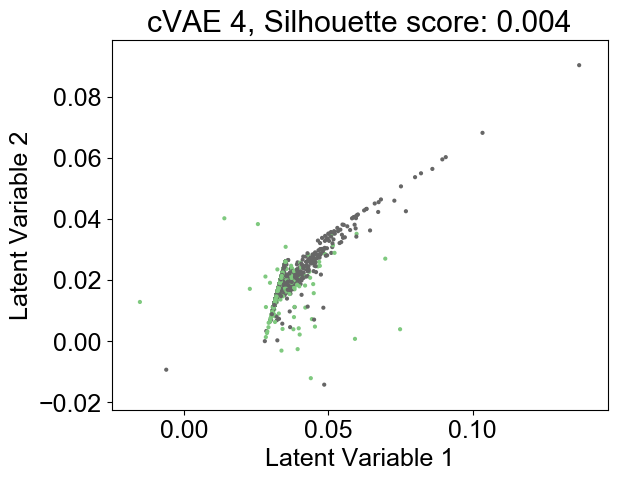

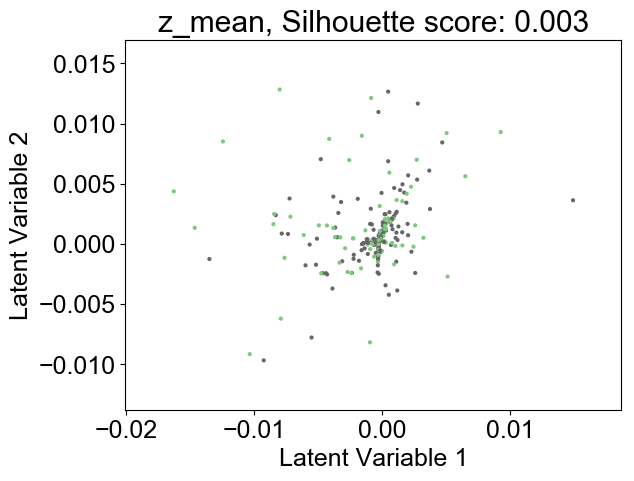

<Figure size 640x480 with 0 Axes>

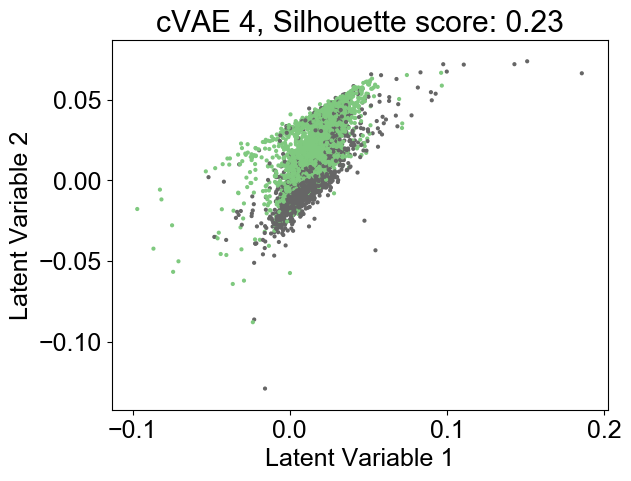

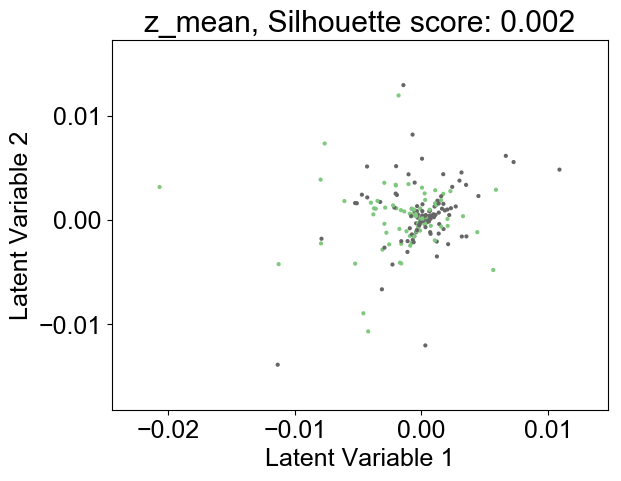

<Figure size 640x480 with 0 Axes>

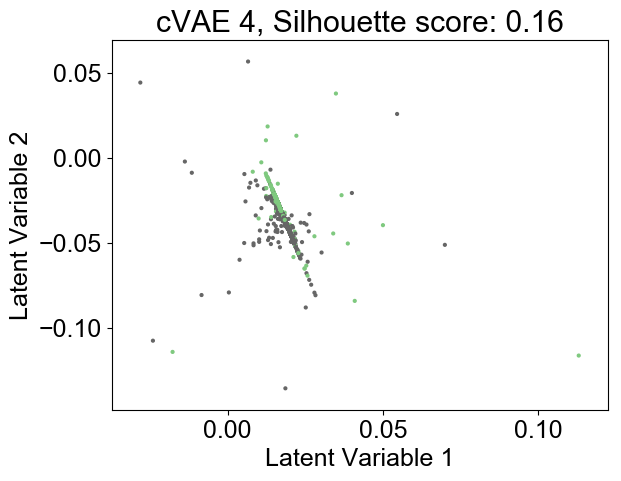

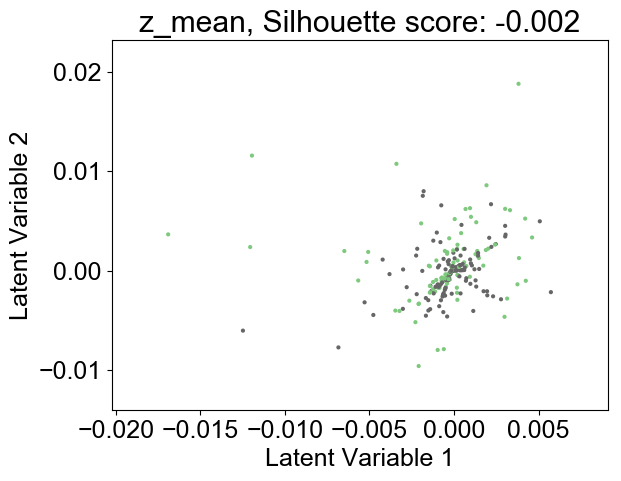

<Figure size 640x480 with 0 Axes>

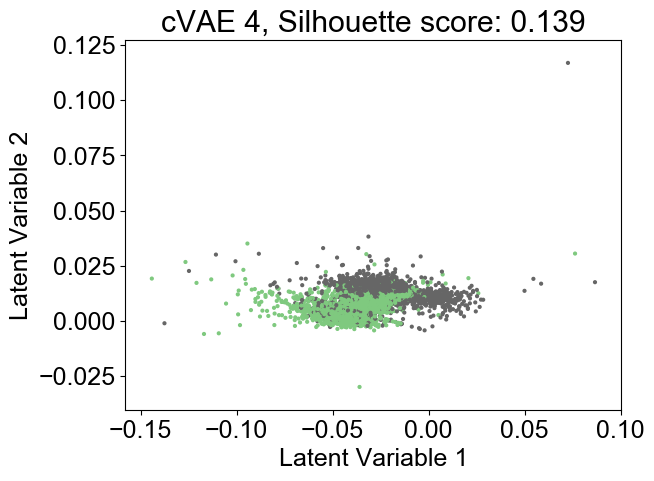

In [ ]:
iters = 10
s_scores = np.zeros((iters,)) 
c_scores = np.zeros((iters,)) 
s_points = list()
c_points = list()

np.random.seed(0)

active_file_idx = [0, 1]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[5]])
latent_dim_s = 4

fname = '0-1-5'

colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']

target = dataset.get_active()
background = dataset.get_bg()
target_labels = dataset.get_active_labels()
n = int(target.shape[0]/128)*128
repeats = int(n/background.shape[0]) + 1

for i in range(iters):
    order = np.random.permutation(n)

    target = target[:n, :][order]
    target_labels = target_labels[:n][order]
    background = np.repeat(background, repeats, axis=0)[:n, :]

    target = (target - target.min())/(target.max() - target.min())
    background = (background - background.min())/(background.max() - background.min())

    vae, encoder, decoder = standard_vae(input_dim=500, intermediate_dim=32, 
                                         latent_dim=2)


    history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
    ss, z_mean = plot_latent_space(encoder, target, target_labels, s=4, return_points=True)
    s_scores[i] = ss
    s_points.append(z_mean)

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
        batch_size = 128, input_dim=500, intermediate_dim=32, latent_dim=2, 
        latent_dim_s=latent_dim_s, disentangle=False, gamma=1)

    history = cvae.fit([target, background], epochs=50, batch_size=128, 
                       validation_data=([target, background], None), verbose=0)


    plt.figure()
    ss, z_mean = plot_latent_space(z_encoder, target, target_labels, name='cVAE ' + str(latent_dim_s), plot=True, s=4, return_points=True)
    c_scores[i] = ss
    c_points.append(z_mean)
    

np.save('rna_results/'+fname+'-s_scores2', s_scores)
np.save('rna_results/'+fname+'-c_scores2', c_scores)
np.save('rna_results/'+fname+'-s_points2', s_points)
np.save('rna_results/'+fname+'-c_points2', c_points)

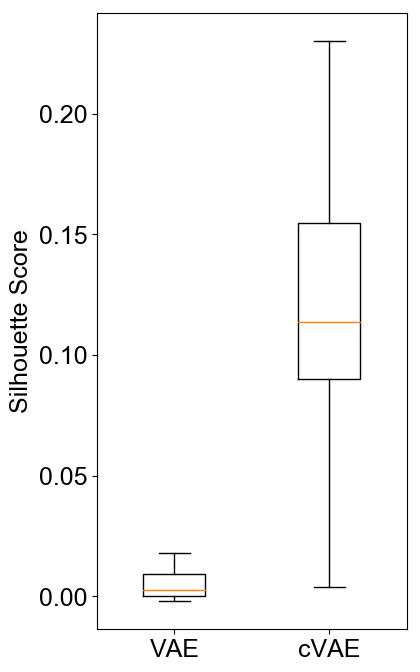

In [ ]:
s_scores = np.load('rna_results/' + fname + '-s_scores2.npy')
c_scores = np.load('rna_results/' + fname + '-c_scores2.npy')
s_points = np.load('rna_results/' + fname + '-s_points2.npy')
c_points = np.load('rna_results/' + fname + '-c_points2.npy')

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[4, 8])
plt.boxplot([s_scores, c_scores], vert=True, widths=0.4)
plt.xticks([1, 2], ['VAE', 'cVAE'])
plt.ylabel('Silhouette Score')
plt.show()

# More than 2 Datasets

### Dataset 0,1,2 | 4

Data size		 (10792, 500)
Active dataset size: 	 (8807, 500)
Background dataset size: (1985, 500)


/home/a12d/home/a12d/contrast_generative/vae_utils.py:896: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


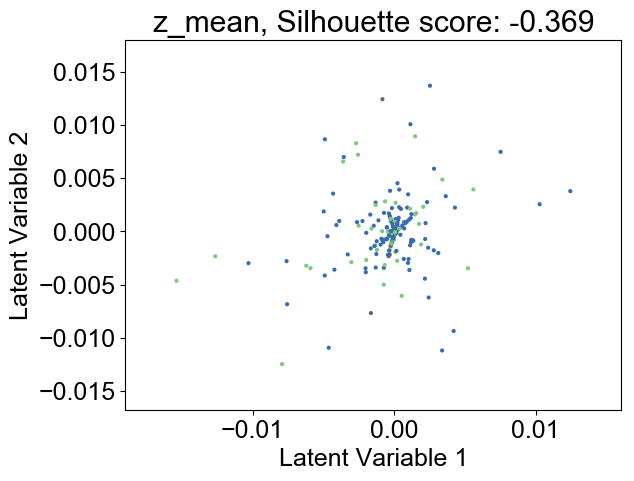

<Figure size 640x480 with 0 Axes>

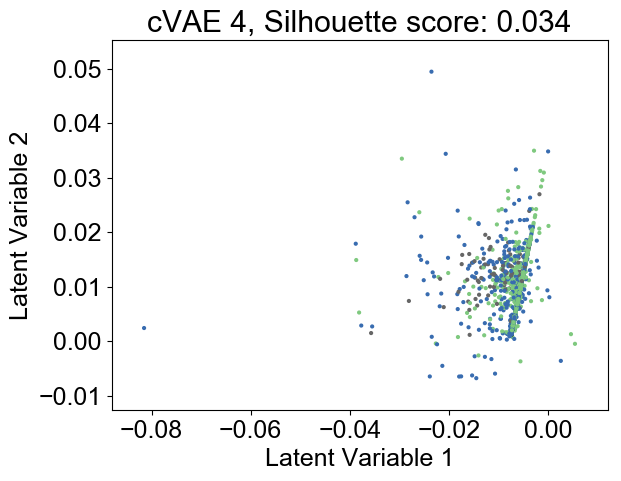

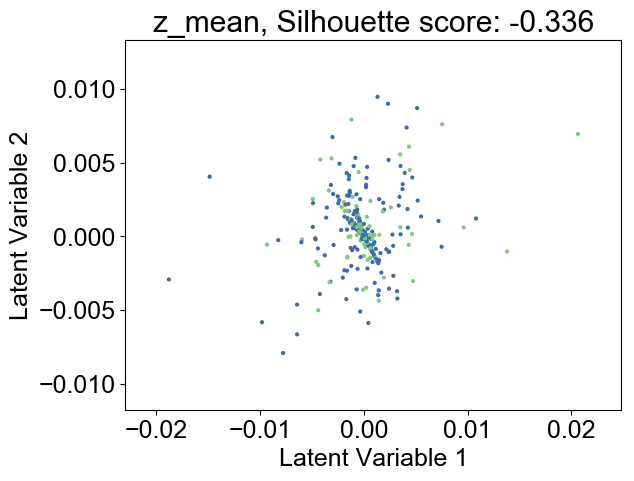

<Figure size 640x480 with 0 Axes>

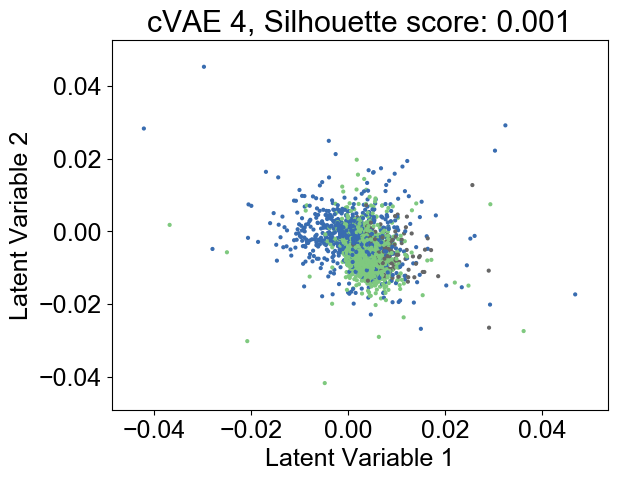

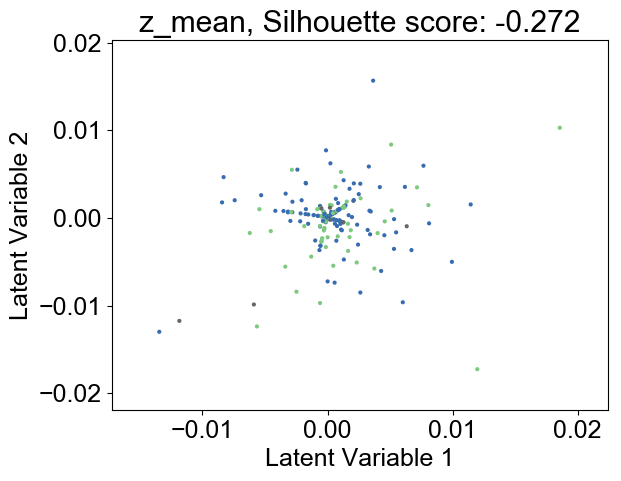

<Figure size 640x480 with 0 Axes>

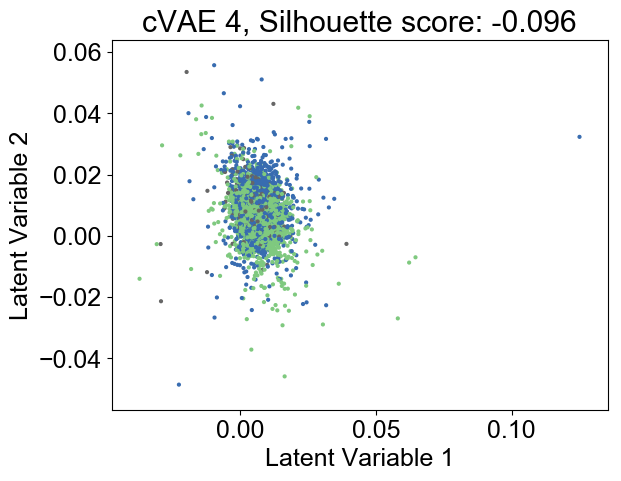

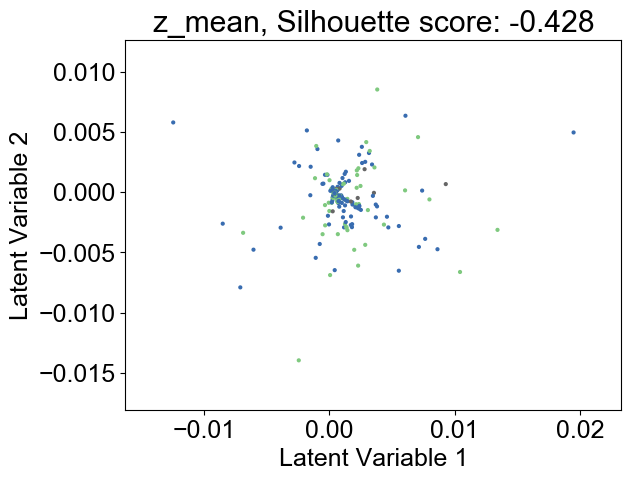

<Figure size 640x480 with 0 Axes>

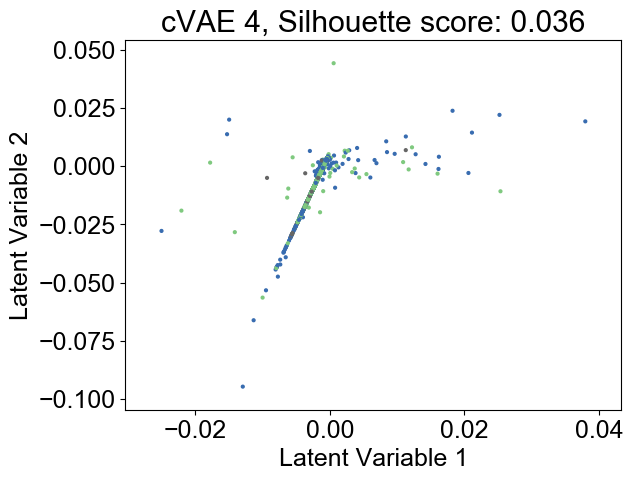

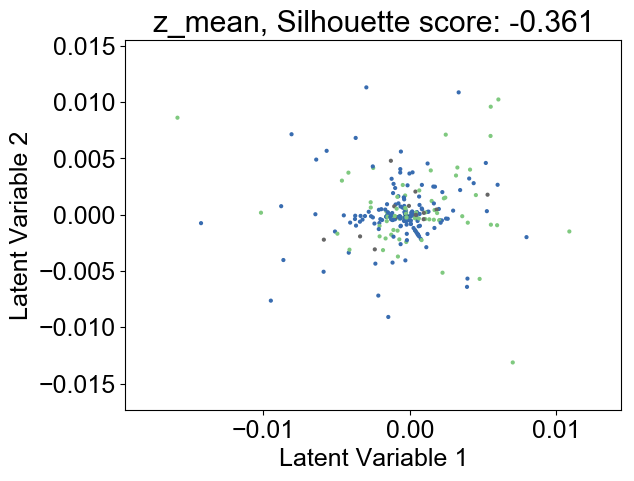

<Figure size 640x480 with 0 Axes>

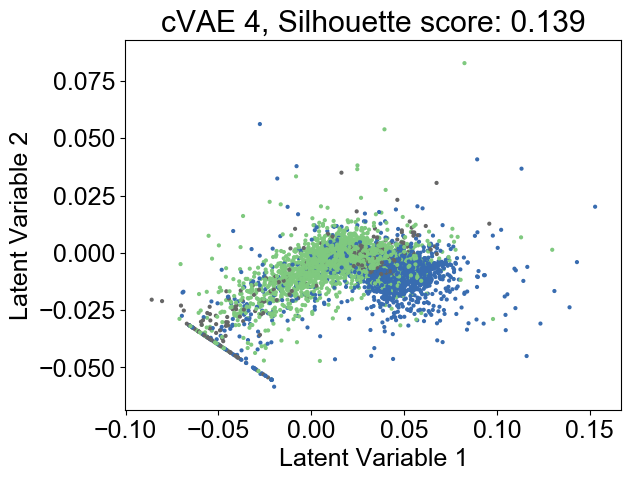

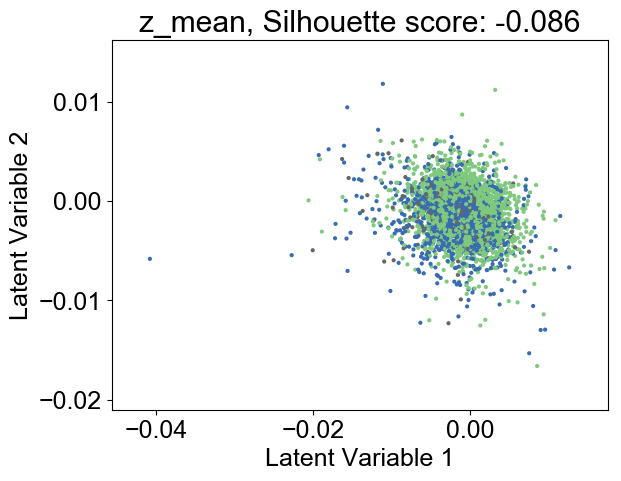

<Figure size 640x480 with 0 Axes>

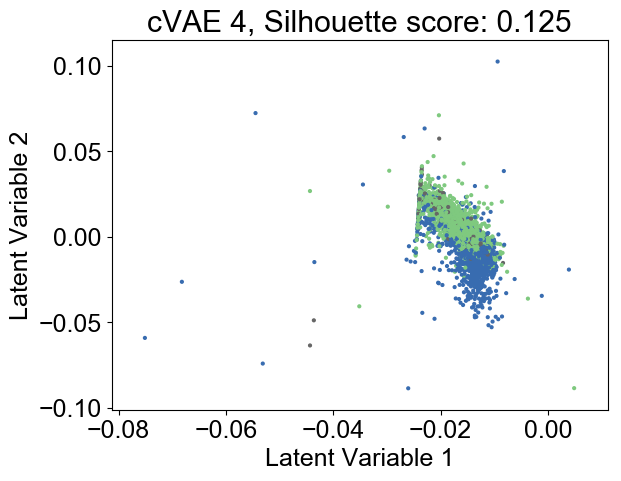

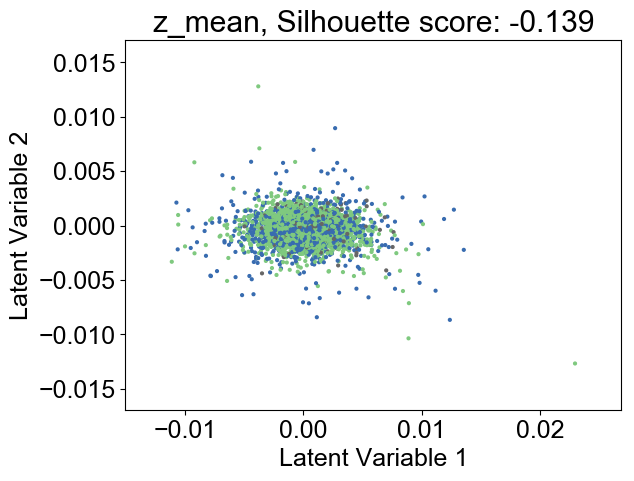

<Figure size 640x480 with 0 Axes>

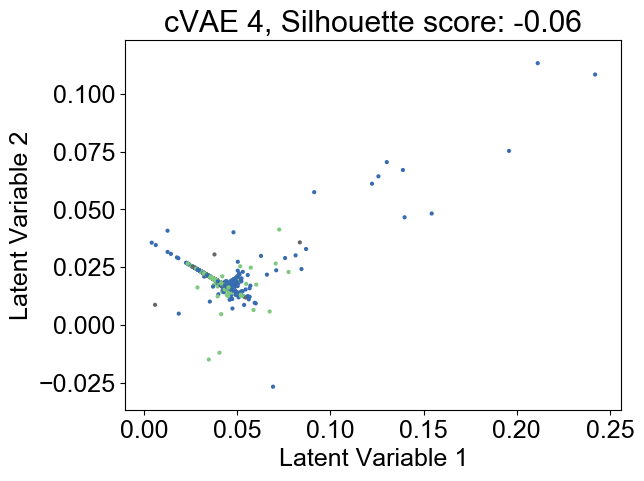

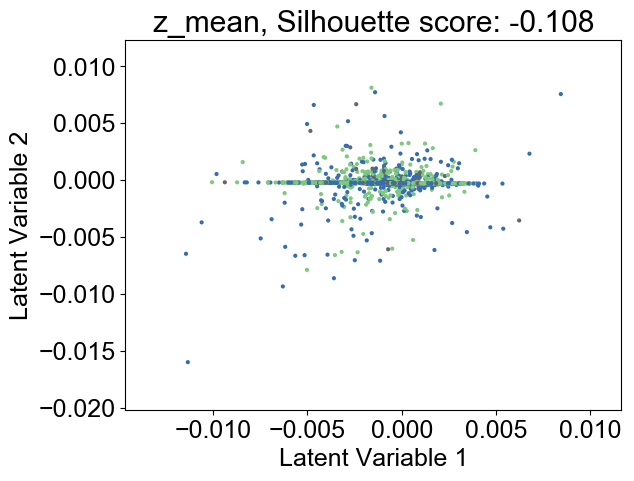

<Figure size 640x480 with 0 Axes>

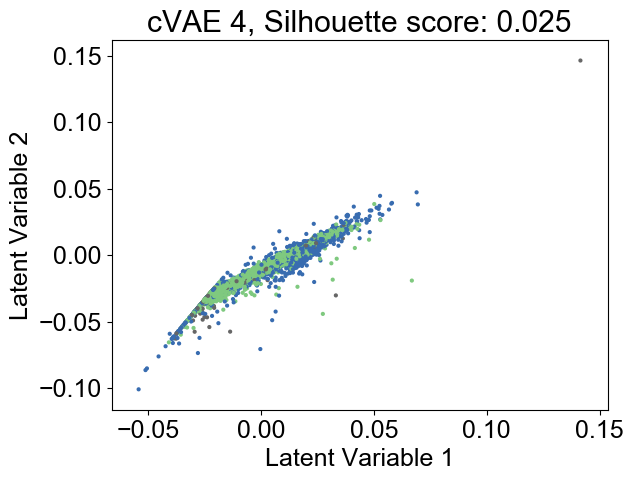

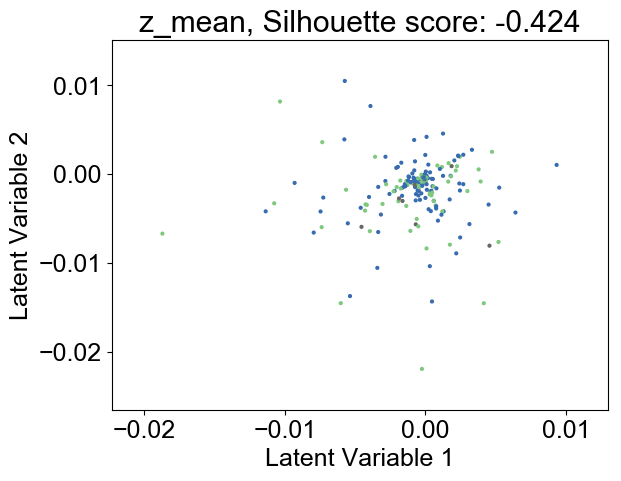

<Figure size 640x480 with 0 Axes>

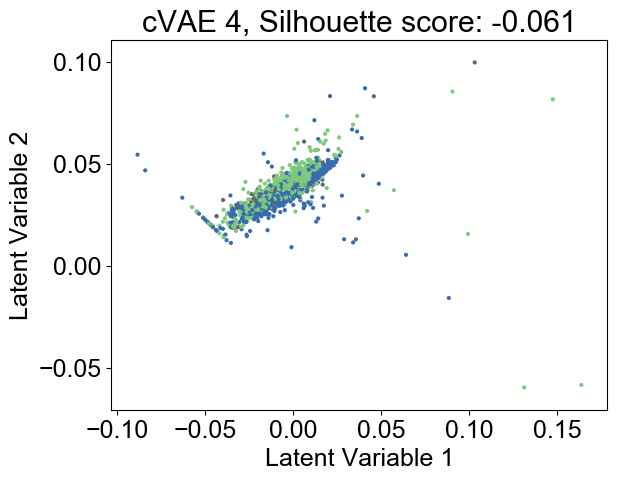

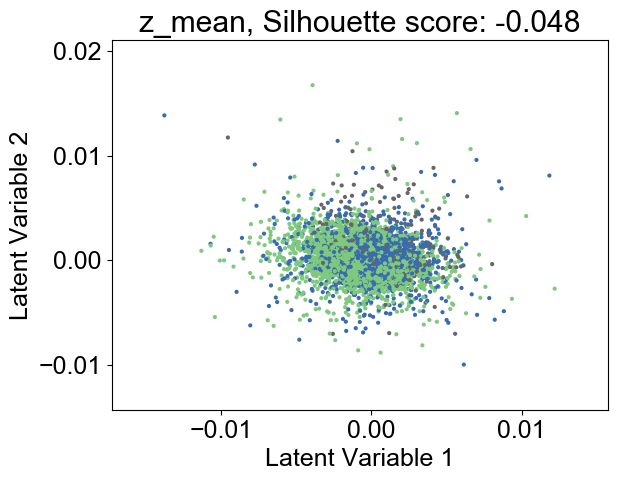

<Figure size 640x480 with 0 Axes>

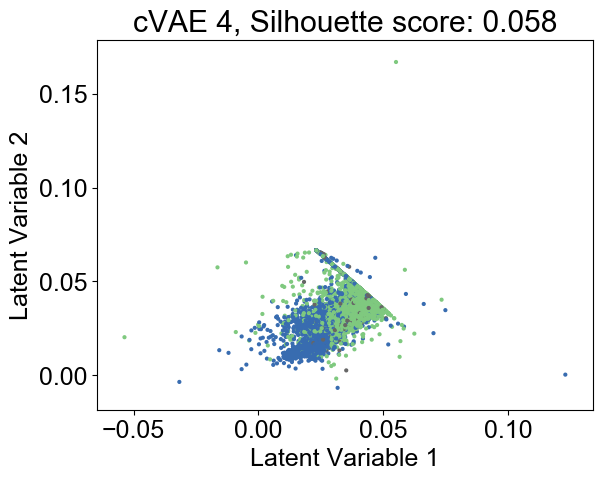

In [ ]:
iters = 10
s_scores = np.zeros((iters,)) 
c_scores = np.zeros((iters,)) 
s_points = list()
c_points = list()

np.random.seed(0)

active_file_idx = [0, 1, 2]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[4]])
latent_dim_s = 4

colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']

target = dataset.get_active()
background = dataset.get_bg()
target_labels = dataset.get_active_labels()
n = int(target.shape[0]/128)*128
repeats = int(n/background.shape[0]) + 1

for i in range(iters):
    order = np.random.permutation(n)

    target = target[:n, :][order]
    target_labels = target_labels[:n][order]
    background = np.repeat(background, repeats, axis=0)[:n, :]

    target = (target - target.min())/(target.max() - target.min())
    background = (background - background.min())/(background.max() - background.min())

    vae, encoder, decoder = standard_vae(input_dim=500, intermediate_dim=32, 
                                         latent_dim=2)


    history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
    ss, z_mean = plot_latent_space(encoder, target, target_labels, s=4, return_points=True)
    s_scores[i] = ss
    s_points.append(z_mean)

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
        batch_size = 128, input_dim=500, intermediate_dim=32, latent_dim=2, 
        latent_dim_s=latent_dim_s, disentangle=False, gamma=1)

    history = cvae.fit([target, background], epochs=50, batch_size=128, 
                       validation_data=([target, background], None), verbose=0)


    plt.figure()
    ss, z_mean = plot_latent_space(z_encoder, target, target_labels, name='cVAE ' + str(latent_dim_s), plot=True, s=4, return_points=True)
    c_scores[i] = ss
    c_points.append(z_mean)
    

np.save('rna_results/0-1-2-4-s_scores2', s_scores)
np.save('rna_results/0-1-2-4-c_scores2', c_scores)
np.save('rna_results/0-1-2-4-s_points2', s_points)
np.save('rna_results/0-1-2-4-c_points2', c_points)

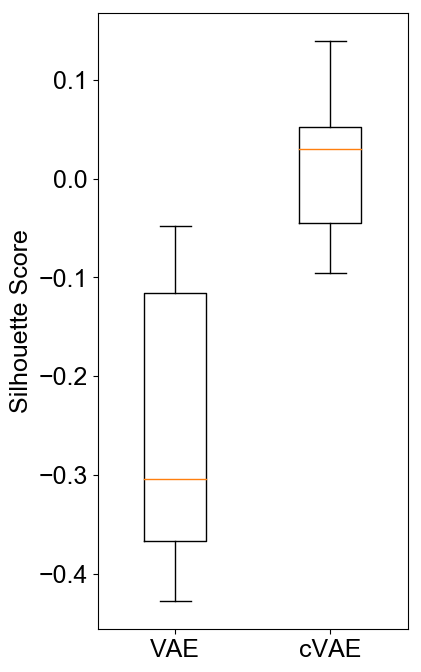

In [ ]:
name = '0-1-2-4'

s_scores = np.load('rna_results/' + name + '-s_scores2.npy')
c_scores = np.load('rna_results/' + name + '-c_scores2.npy')
s_points = np.load('rna_results/' + name + '-s_points2.npy')
c_points = np.load('rna_results/' + name + '-c_points2.npy')

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[4, 8])
plt.boxplot([s_scores, c_scores], vert=True, widths=0.4)
plt.xticks([1, 2], ['VAE', 'cVAE'])
plt.ylabel('Silhouette Score')
plt.show()

### Dataset 0,1,2,3 | 4

Data size		 (14384, 500)
Active dataset size: 	 (12399, 500)
Background dataset size: (1985, 500)


/home/a12d/home/a12d/contrast_generative/vae_utils.py:896: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


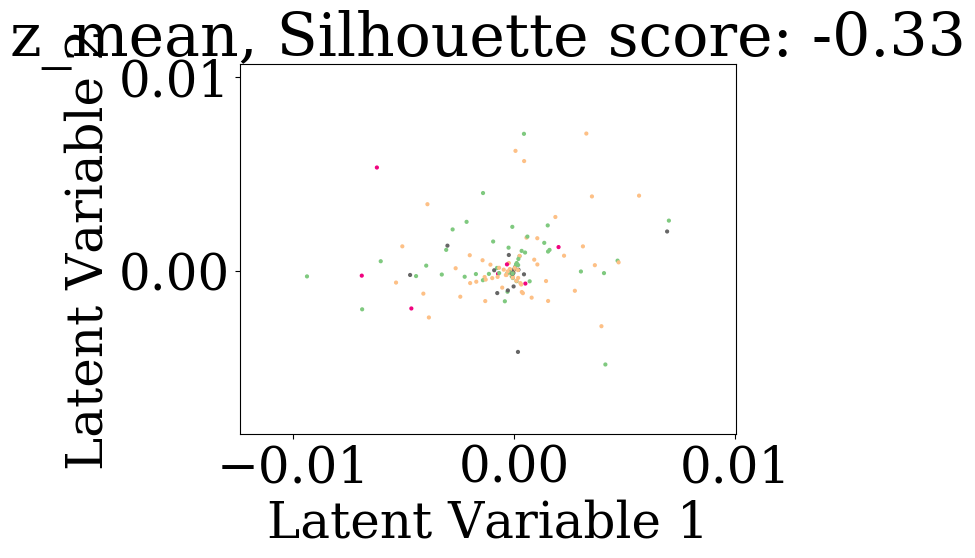

<Figure size 640x480 with 0 Axes>

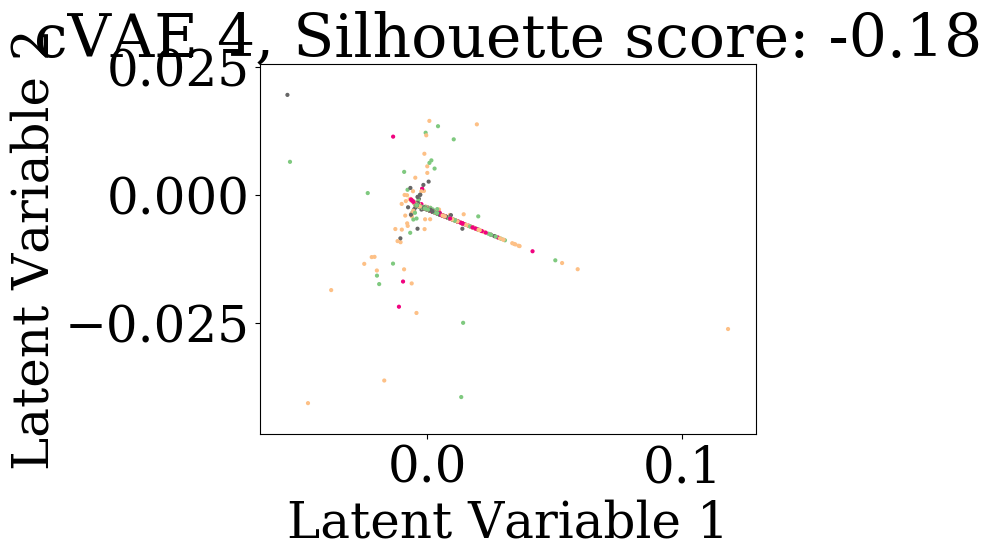

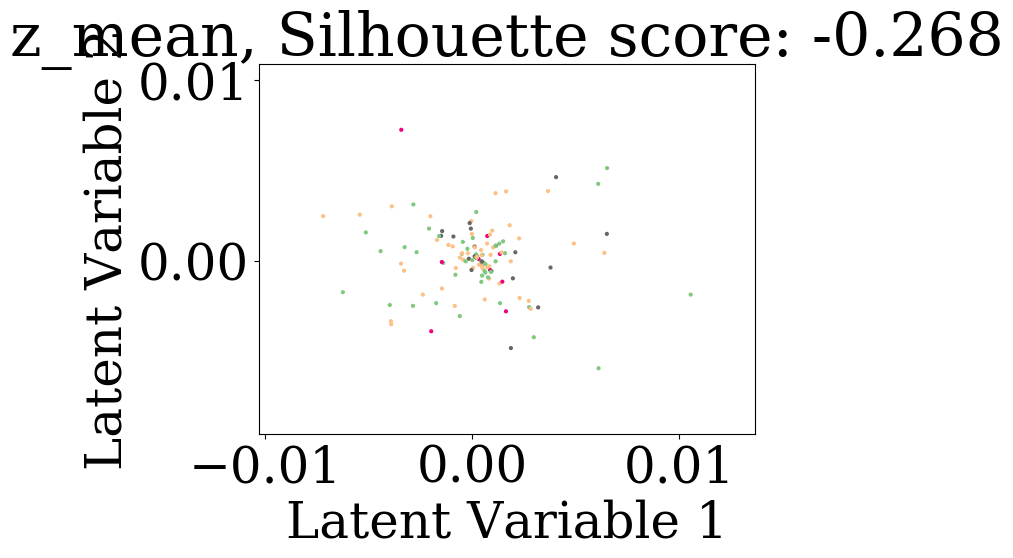

<Figure size 640x480 with 0 Axes>

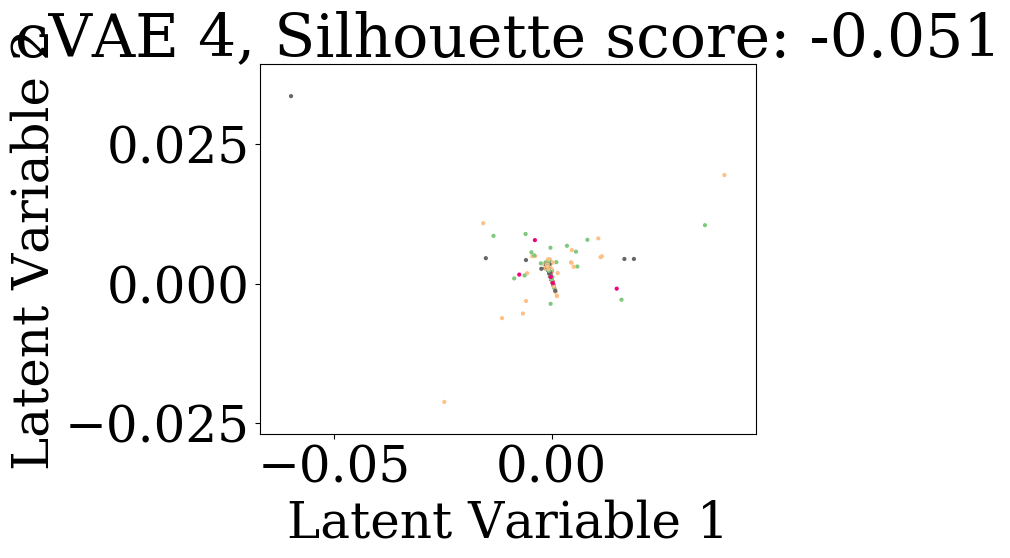

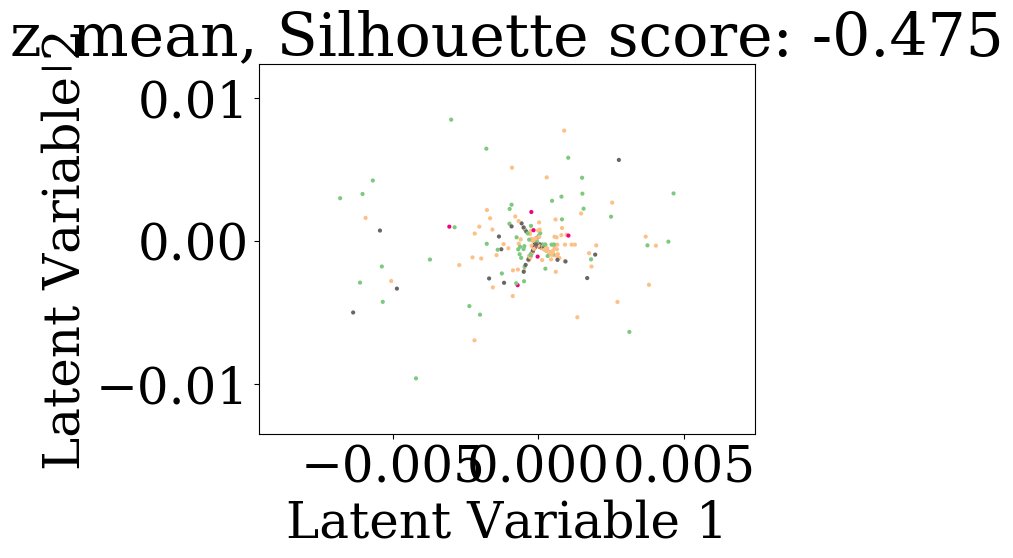

<Figure size 640x480 with 0 Axes>

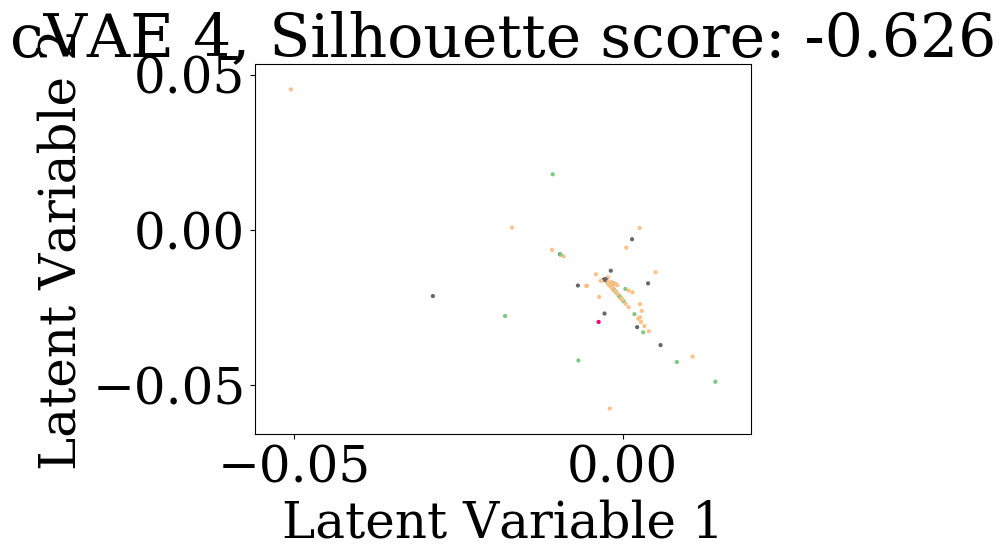

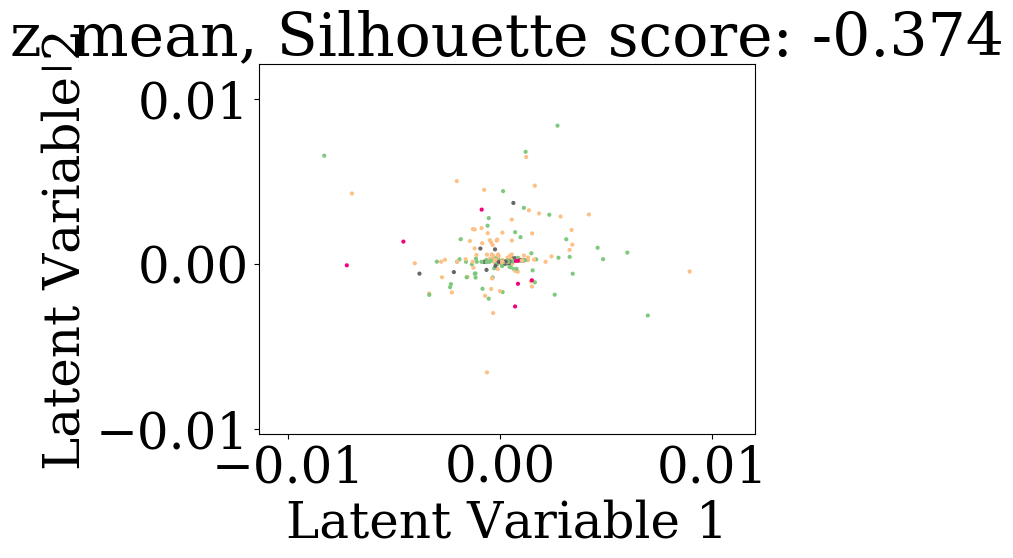

<Figure size 640x480 with 0 Axes>

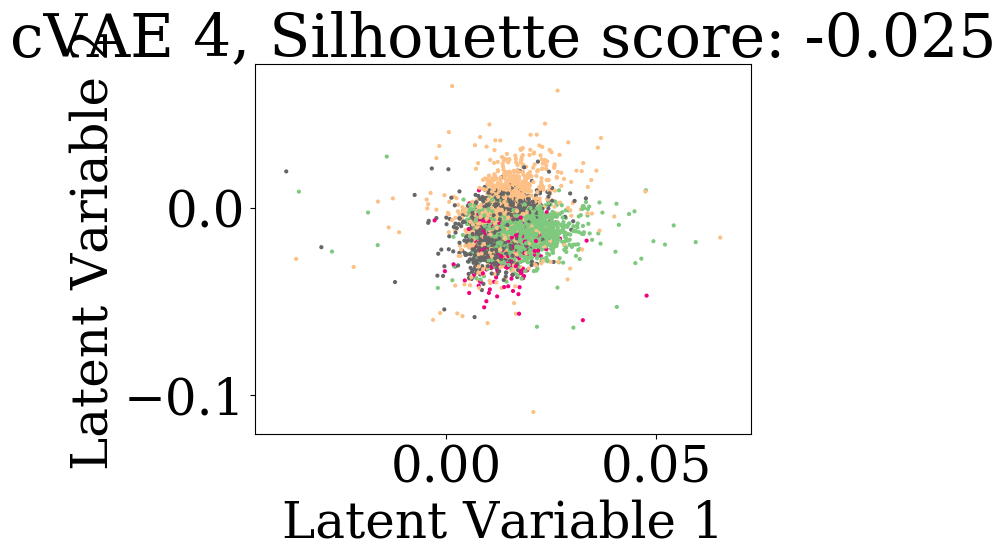

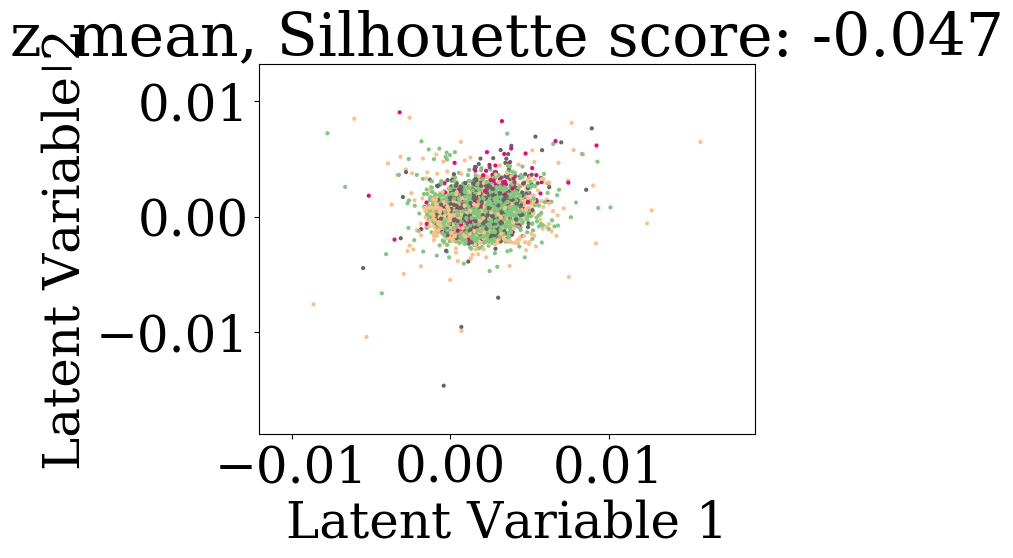

<Figure size 640x480 with 0 Axes>

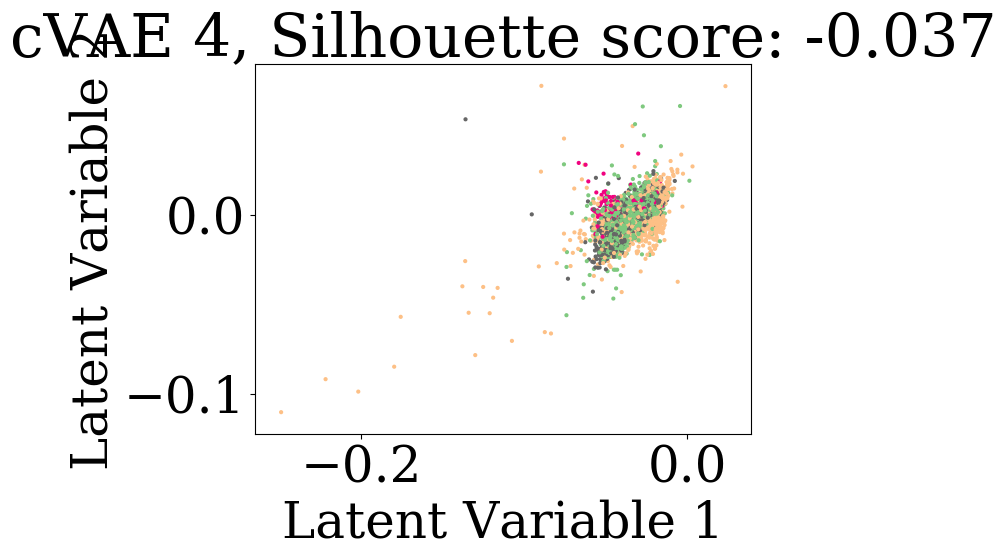

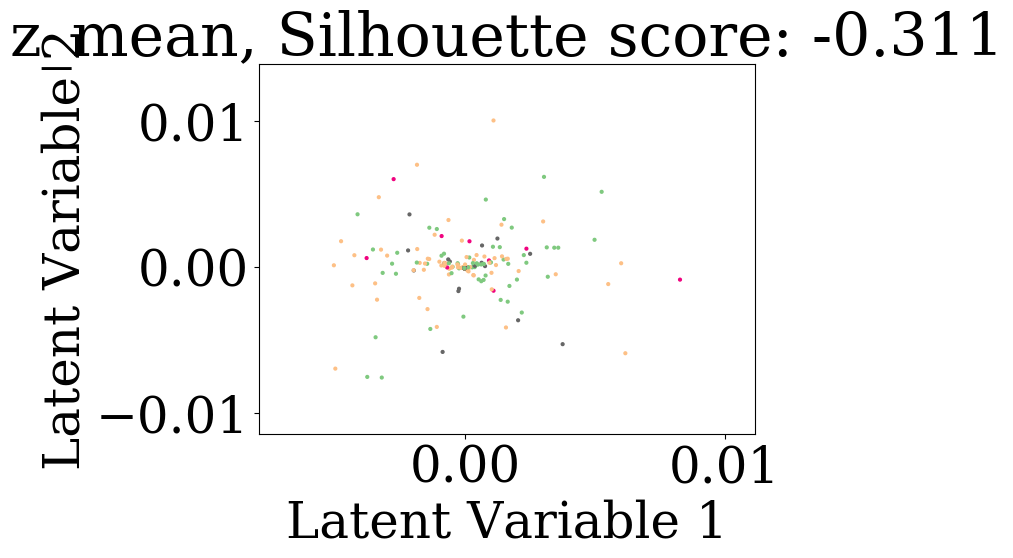

<Figure size 640x480 with 0 Axes>

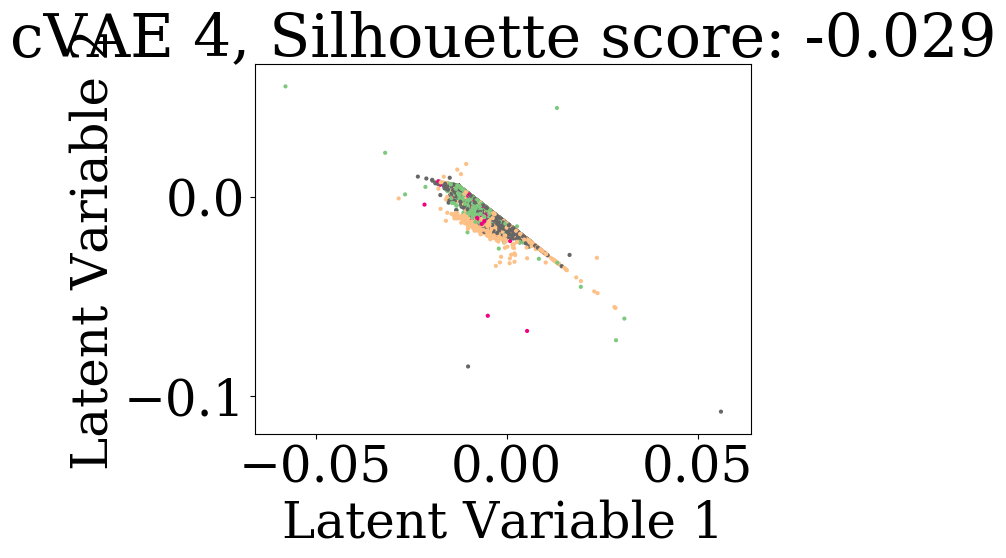

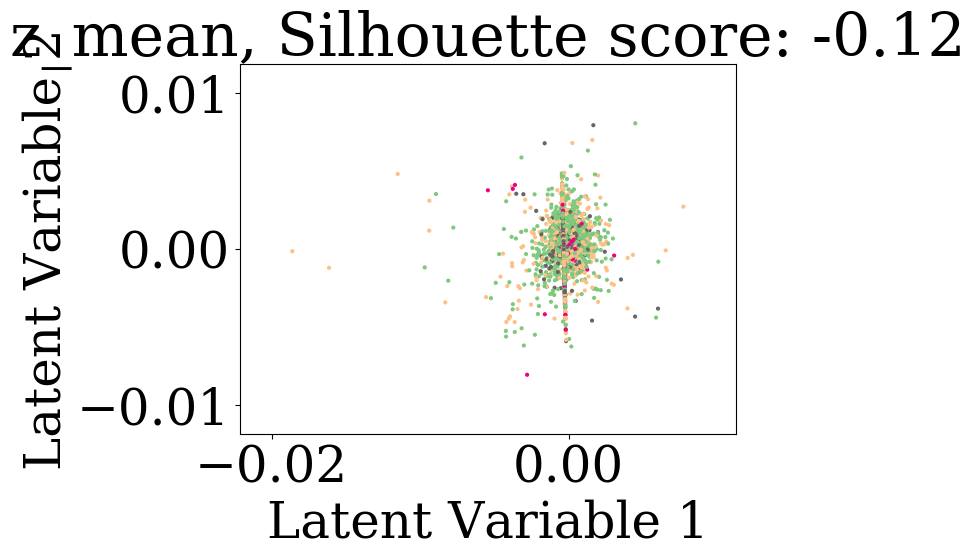

<Figure size 640x480 with 0 Axes>

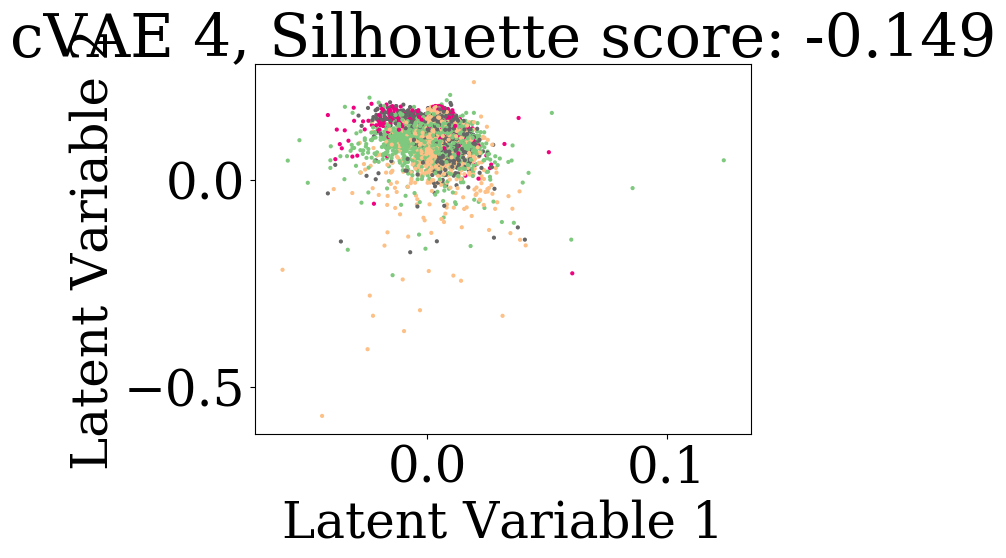

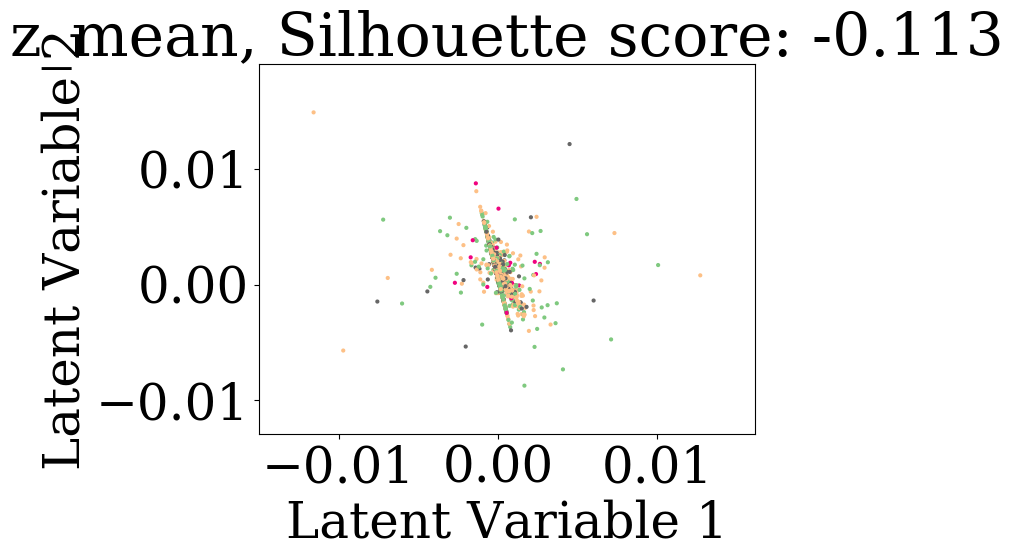

<Figure size 640x480 with 0 Axes>

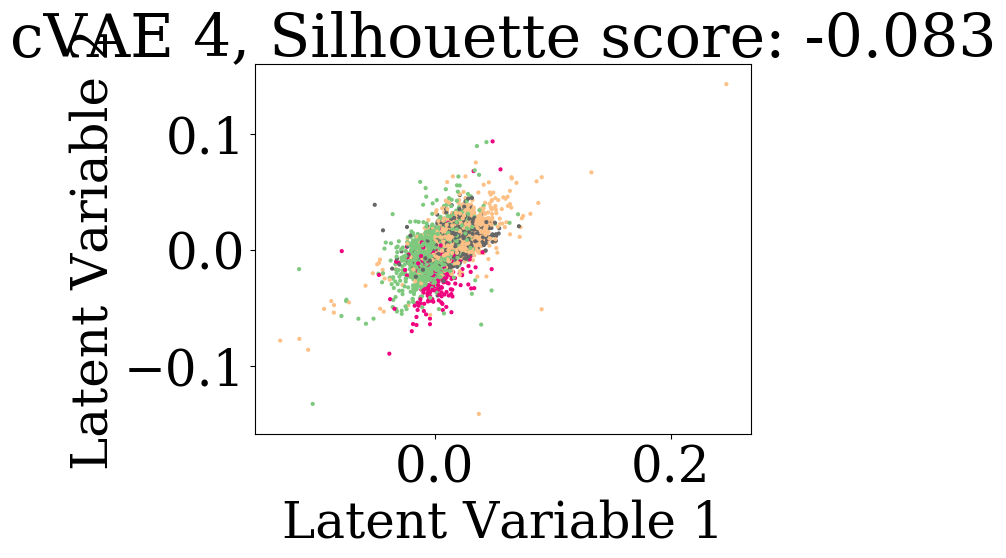

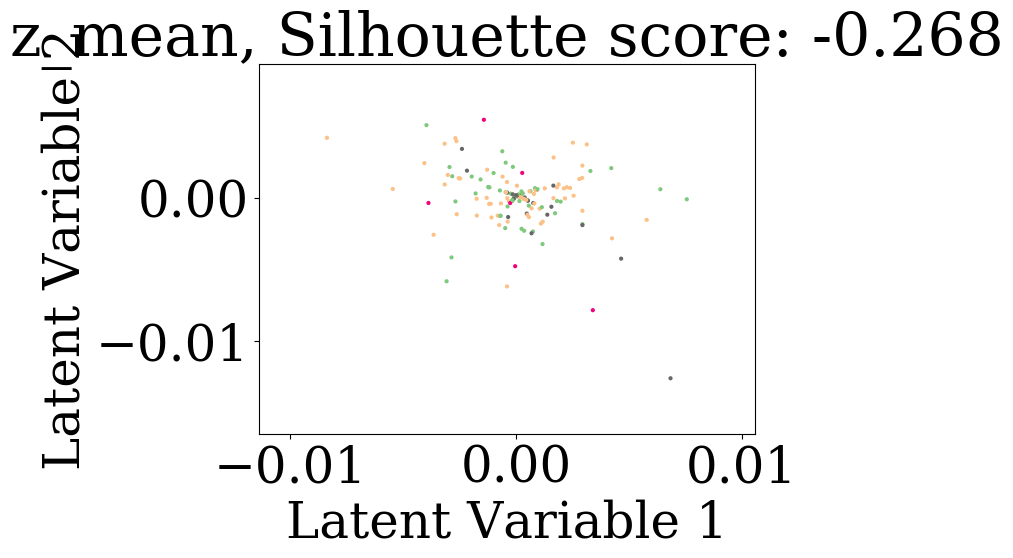

<Figure size 640x480 with 0 Axes>

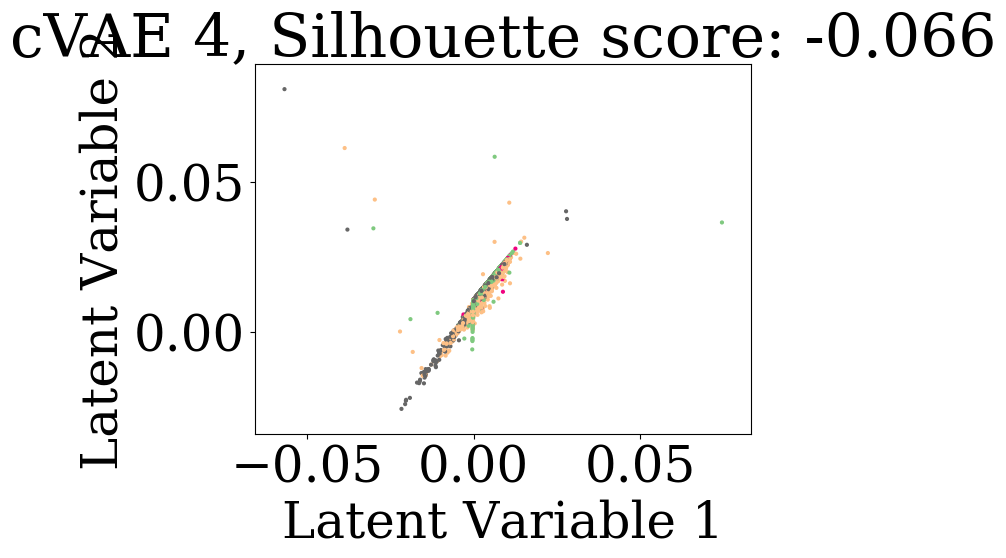

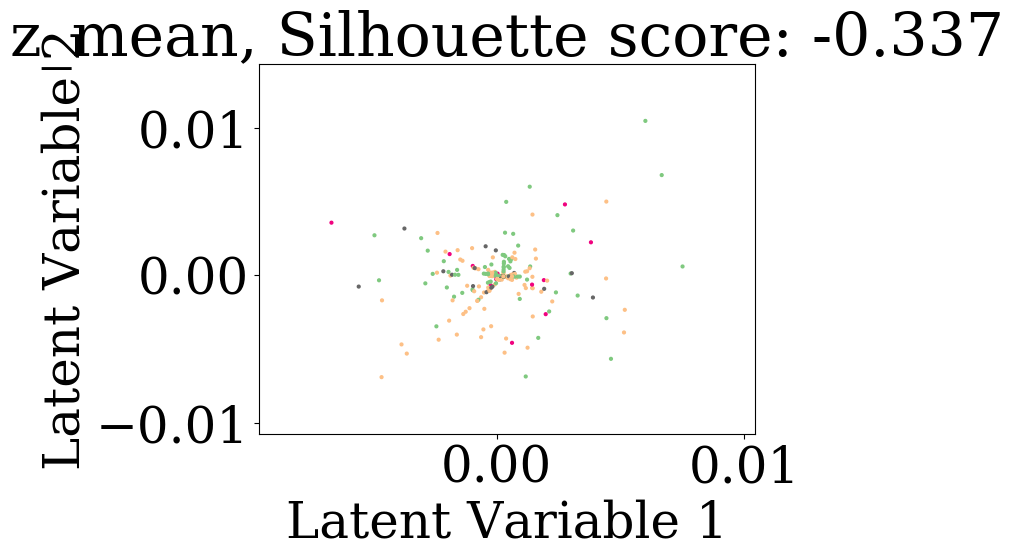

<Figure size 640x480 with 0 Axes>

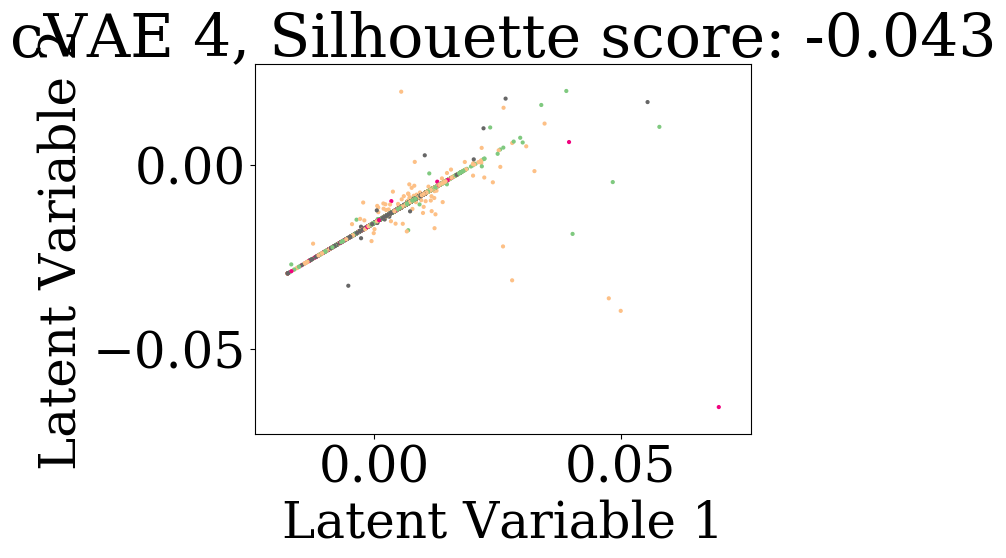

In [ ]:
iters = 10
s_scores = np.zeros((iters,)) 
c_scores = np.zeros((iters,)) 
s_points = list()
c_points = list()

np.random.seed(0)

active_file_idx = [0, 1, 2, 3]
dataset = SingleCell(itemgetter(*active_file_idx)(fnames), [fnames[4]])
latent_dim_s = 4

colors = ['#1f77b4','#d62728', '#2ca02c', '#ff7f0e']

target = dataset.get_active()
background = dataset.get_bg()
target_labels = dataset.get_active_labels()
n = int(target.shape[0]/128)*128
repeats = int(n/background.shape[0]) + 1

for i in range(iters):
    order = np.random.permutation(n)

    target = target[:n, :][order]
    target_labels = target_labels[:n][order]
    background = np.repeat(background, repeats, axis=0)[:n, :]

    target = (target - target.min())/(target.max() - target.min())
    background = (background - background.min())/(background.max() - background.min())

    vae, encoder, decoder = standard_vae(input_dim=500, intermediate_dim=32, 
                                         latent_dim=2)


    history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
    ss, z_mean = plot_latent_space(encoder, target, target_labels, s=4, return_points=True)
    s_scores[i] = ss
    s_points.append(z_mean)

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
        batch_size = 128, input_dim=500, intermediate_dim=32, latent_dim=2, 
        latent_dim_s=latent_dim_s, disentangle=False, gamma=1)

    history = cvae.fit([target, background], epochs=50, batch_size=128, 
                       validation_data=([target, background], None), verbose=0)


    plt.figure()
    ss, z_mean = plot_latent_space(z_encoder, target, target_labels, name='cVAE ' + str(latent_dim_s), plot=True, s=4, return_points=True)
    c_scores[i] = ss
    c_points.append(z_mean)
    

np.save('rna_results/0-1-2-3-4-s_scores2', s_scores)
np.save('rna_results/0-1-2-3-4-c_scores2', c_scores)
np.save('rna_results/0-1-2-3-4-s_points2', s_points)
np.save('rna_results/0-1-2-3-4-c_points2', c_points)

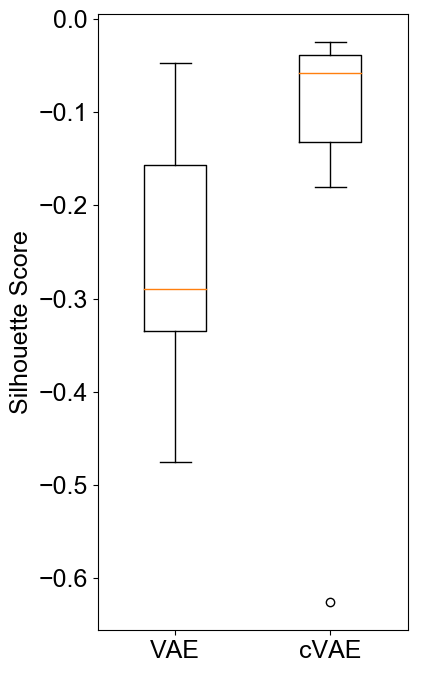

In [ ]:
name = '0-1-2-3-4'

s_scores = np.load('rna_results/' + name + '-s_scores2.npy')
c_scores = np.load('rna_results/' + name + '-c_scores2.npy')
s_points = np.load('rna_results/' + name + '-s_points2.npy')
c_points = np.load('rna_results/' + name + '-c_points2.npy')

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[4, 8])
plt.boxplot([s_scores, c_scores], vert=True, widths=0.4)
plt.xticks([1, 2], ['VAE', 'cVAE'])
plt.ylabel('Silhouette Score')
plt.show()